<a href="https://colab.research.google.com/github/IngwarHighlander/Data-Analytics-Public/blob/main/Exploratory_data_analysis_for_online_furniture_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploratory data analysis for online furniture store**

In [1]:
# Installation of the library to work with Google BigQuery:
!pip install --upgrade google-cloud-bigquery

In [2]:
# Import of modules for authentication and working with BigQuery and libraries for processing query results:
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
# Authentication to work with Google Cloud:
auth.authenticate_user()

In [4]:
# Creation of a client to work with BigQuery:
client = bigquery.Client(project="data-analytics-mate")

In [5]:
# SQL query
query = """
SELECT
s.date,
s.ga_session_id as session_id,
sp.continent,
sp.country,
sp.device,
sp.browser,
sp.mobile_model_name,
sp.operating_system,
sp.language,
sp.medium,
sp.channel,
acs.account_id as user_id,
acc.is_verified,
acc.is_unsubscribed,
p.category,
p.name as product_name,
p.price,
p.short_description
FROM `DA.session` s
JOIN `DA.session_params` sp
ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `DA.account_session` acs
ON s.ga_session_id = acs.ga_session_id
LEFT JOIN `DA.account` acc
ON acs.account_id = acc.id
LEFT JOIN `DA.order` o
ON s.ga_session_id = o.ga_session_id
LEFT JOIN `DA.product` p
ON o.item_id = p.item_id
"""

# Execution of SQL query
query_job = client.query(query)
# Waiting for the request to complete
results = query_job.result()
# Outputting results
df = results.to_dataframe()
df

,date,session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,user_id,is_verified,is_unsubscribed,category,product_name,price,short_description
0,2021-01-19,7268004754,(not set),(not set),desktop,Chrome,Chrome,Web,en-gb,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
1,2021-01-06,8321293308,(not set),(not set),desktop,Chrome,Chrome,Web,None,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
2,2020-11-05,4392362373,(not set),(not set),desktop,Chrome,Chrome,Web,None,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
3,2020-12-09,140108698,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(none),Direct,<NA>,<NA>,<NA>,None,None,NaN,None
4,2020-11-10,8351127264,(not set),(not set),mobile,Safari,iPhone,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349540,2020-11-25,353517,Americas,Canada,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
349541,2020-11-09,2536581233,Americas,United States,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
349542,2021-01-02,2149190429,Americas,Canada,desktop,Chrome,Safari,Macintosh,de,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None
349543,2021-01-08,6004211753,Americas,United States,desktop,Chrome,Safari,Macintosh,None,(data deleted),Undefined,<NA>,<NA>,<NA>,None,None,NaN,None


# Overal description of the dataset

In [6]:
# number of rows and columns:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 349545
Number of columns: 18


In [7]:
# type of rows and their counts:
print(df.dtypes)
print('\n')
print(df.dtypes.value_counts())

date                  dbdate
session_id             Int64
continent             object
country               object
device                object
browser               object
mobile_model_name     object
operating_system      object
language              object
medium                object
channel               object
user_id                Int64
is_verified            Int64
is_unsubscribed        Int64
category              object
product_name          object
price                float64
short_description     object
dtype: object


object     12
Int64       4
dbdate      1
float64     1
Name: count, dtype: int64


In [8]:
# number of unique sessions
unique_sessions = df['session_id'].nunique()
print(f"Number of unique sessions: {unique_sessions}\n")


Number of unique sessions: 349545



In [9]:
# time period under consideration
date_range_start = df['date'].min()
date_range_end = df['date'].max()
print(f'Time period: {date_range_start} — {date_range_end}')
print(f'Duration: {date_range_end - date_range_start}')

Time period: 2020-11-01 — 2021-01-31
Duration: 91 days, 0:00:00


In [10]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [11]:
# defining common placeholders representing missing values
missing_placeholders = ['(not set)', 'None', '<NA>', '(data deleted)', 'NaN']

df_with_na = df.replace(missing_placeholders, np.nan)

missing_values = df_with_na.isna().sum()
total_missing = missing_values.sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

print("Missing values:")
if not missing_values.empty:
    print(f"\n   Total number of missing values: {total_missing}")
    print(f"\nMissing values by rows:\n{missing_values.to_string()}")
else:
    print("   There are no missing values.")

Missing values:

   Total number of missing values: 2368556

Missing values by rows:
is_unsubscribed      321600
is_verified          321600
user_id              321600
price                316007
product_name         316007
short_description    316007
category             316007
language             114266
medium                21859
country                2808
continent               795


**Remarks regarding missing values:**

- The large number of missing values can be explained by two main factors: (1)the number of registered users is relatively small, while our analysis covers all orders and sessions — including those from unregistered users; (2) many missing values in product-related fields are due to the dataset containing all user sessions, even those where no products were viewed or purchased.
- Price-related fields (such as price, product_name, category, and short_description) do not require additional data cleaning during sales analysis, as rows without valid price values will already be excluded.
- User-related fields (is_unsubscribed, is_verified, user_id) will be cleaned as needed during user-focused analyses.
- Geographical fields (country, continent) will be cleaned only if missing or inconsistent values are found to affect the results.

# **ANALYSIS**

## **Geographical Analysis of Sales**

In [12]:
# Preparation of the dataset
sales_df = df[df['price'] > 0].copy()

print(f"Total sales during the period: {sales_df['price'].sum()}")

# TOP-3 continents by sales
sales_by_continent = sales_df.groupby('continent')['price'].sum().sort_values(ascending=False)
print("\nTOP-3 continents by sales:")
print(sales_by_continent.head(3).to_string())

# TOP-5 countries by sales
sales_by_country = sales_df.groupby('country')['price'].sum().sort_values(ascending=False)
print("\nTOP-5 countries by sales:")
print(sales_by_country.head(5).to_string())

Total sales during the period: 31971731.1

TOP-3 continents by sales:
continent
Americas    17665280.0
Asia         7601298.3
Europe       5934624.2

TOP-5 countries by sales:
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8


In [13]:
# Geographical analysis of orders
orders_df = df[df['price'] > 0].copy()

print(f"\nTotal orders during the period: {orders_df['price'].count()}")

# TOP-3 continents by number of orders
orders_by_continent = orders_df.groupby('continent')['price'].count().sort_values(ascending=False)
print("\nTOP-3 continents by number of orders:")
print(orders_by_continent.head(3).to_string())

# TOP-5 countries by number of orders
orders_by_country = orders_df.groupby('country')['price'].count().sort_values(ascending=False)
print("\nTOP-5 countries by number of orders:")
print(orders_by_country.head(5).to_string())


Total orders during the period: 33538

TOP-3 continents by number of orders:
continent
Americas    18553
Asia         7950
Europe       6261

TOP-5 countries by number of orders:
country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678


TOP-10 product categories by sales:
category
Sofas & armchairs                   8388254.5
Chairs                              6147748.8
Beds                                4919725.0
Bookcases & shelving units          3640818.1
Cabinets & cupboards                2336499.5
Outdoor furniture                   2142222.2
Tables & desks                      1790307.5
Chests of drawers & drawer units     906562.5
Bar furniture                        735503.0
Children's furniture                 467697.0


/tmp/ipython-input-14-2825451718.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


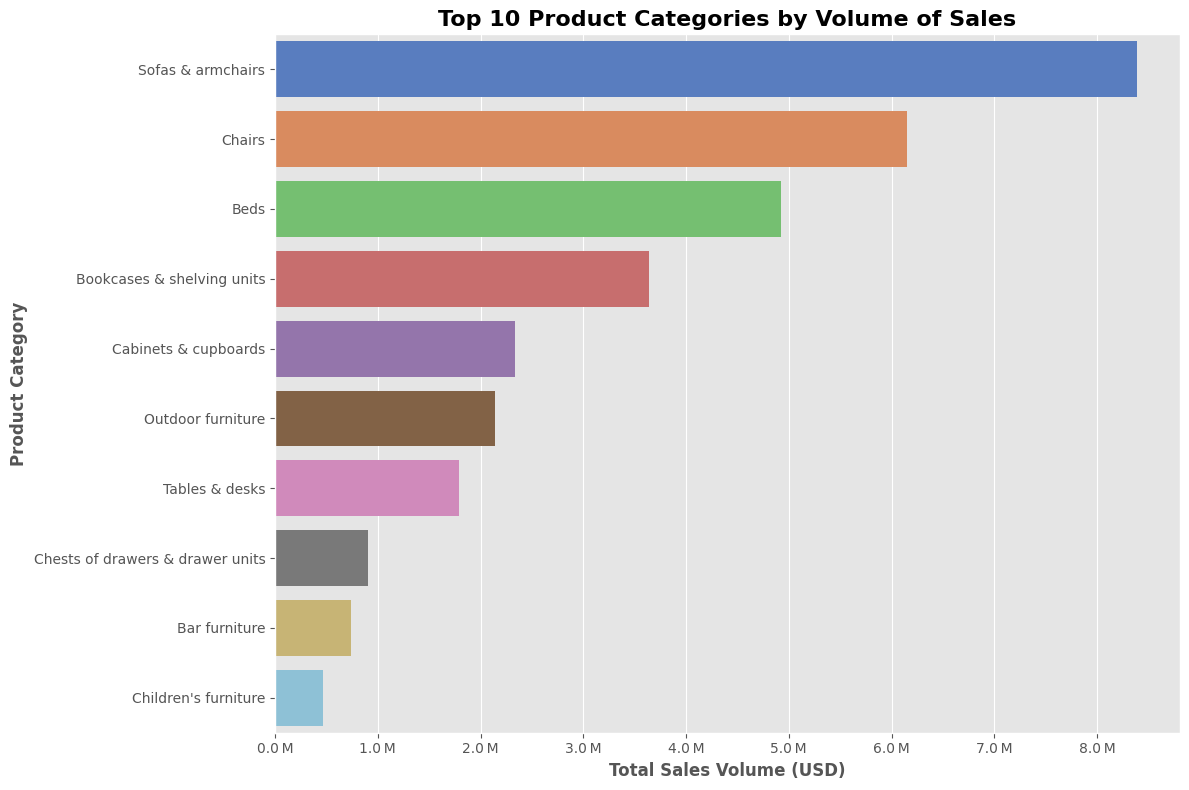

In [14]:
# TOP product categories by sales

# grouping and aggregating sales by category
overall_top10_categories = sales_df.groupby('category')['price'].sum().sort_values(ascending=False).head(10)

# text output
print("TOP-10 product categories by sales:")
print(overall_top10_categories.to_string())

# plotting a chart
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))

sns.barplot(
    x=overall_top10_categories.values,
    y=overall_top10_categories.index,
    palette="muted"
)

# chart labels and formatting
plt.xlabel("Total Sales Volume (USD)", fontsize=12, weight="bold")
plt.ylabel("Product Category", fontsize=12, weight="bold")
plt.title("Top 10 Product Categories by Volume of Sales", fontsize=16, weight="bold")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1_000_000:.1f} M"))
plt.tight_layout()
plt.show()

In [15]:
# Comparison of sales in top-selling country with overal sales

# identification the top‑selling country
sales_by_country = sales_df.groupby('country')['price'].sum()
top_country = sales_by_country.idxmax()

# text output
print(f"Top‑selling country: {top_country}\n"
      f"Total sales there: {sales_by_country.max():,.2f}\n")

# identification of TOP-selling product categories
overall_top10_categories = (sales_df.groupby('category')['price'].sum().nlargest(10).rename('overall_total'))
country_top10_categories = (sales_df.query('country == @top_country').groupby('category')['price'].sum().nlargest(10).rename('country_total'))

#tabular comparison
comparison = (
    pd.concat([overall_top10_categories, country_top10_categories], axis=1)
      .fillna(0)
      .assign(share_pct=lambda df: (df.country_total / df.overall_total * 100)
                                    .round(1))
      .sort_values('overall_total', ascending=False)
)

print("Comparison (overall vs. top country):")
print(comparison.to_string(float_format='{:,.0f}'.format), "\n")

unique_to_country = set(country_top10_categories.index) - set(overall_top10_categories.index)
unique_to_overall = set(overall_top10_categories.index) - set(country_top10_categories.index)

if unique_to_country or unique_to_overall:
    print("➤ Categories unique to the top country list:",
          ", ".join(sorted(unique_to_country)) or "None")
    print("➤ Categories unique to the overall list:",
          ", ".join(sorted(unique_to_overall)) or "None")
else:
    print("➤ The two lists contain exactly the same categories.")



Top‑selling country: United States
Total sales there: 13,943,553.90

Comparison (overall vs. top country):
                                  overall_total  country_total  share_pct
category                                                                 
Sofas & armchairs                     8,388,254      3,707,144         44
Chairs                                6,147,749      2,619,774         43
Beds                                  4,919,725      2,213,058         45
Bookcases & shelving units            3,640,818      1,567,607         43
Cabinets & cupboards                  2,336,500        994,546         43
Outdoor furniture                     2,142,222        929,245         43
Tables & desks                        1,790,308        777,865         43
Chests of drawers & drawer units        906,562        382,388         42
Bar furniture                           735,503        330,805         45
Children's furniture                    467,697        207,575         44 

➤ T

/tmp/ipython-input-16-3552989708.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overall_top10_categories.values,
/tmp/ipython-input-16-3552989708.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_top10_categories.values,


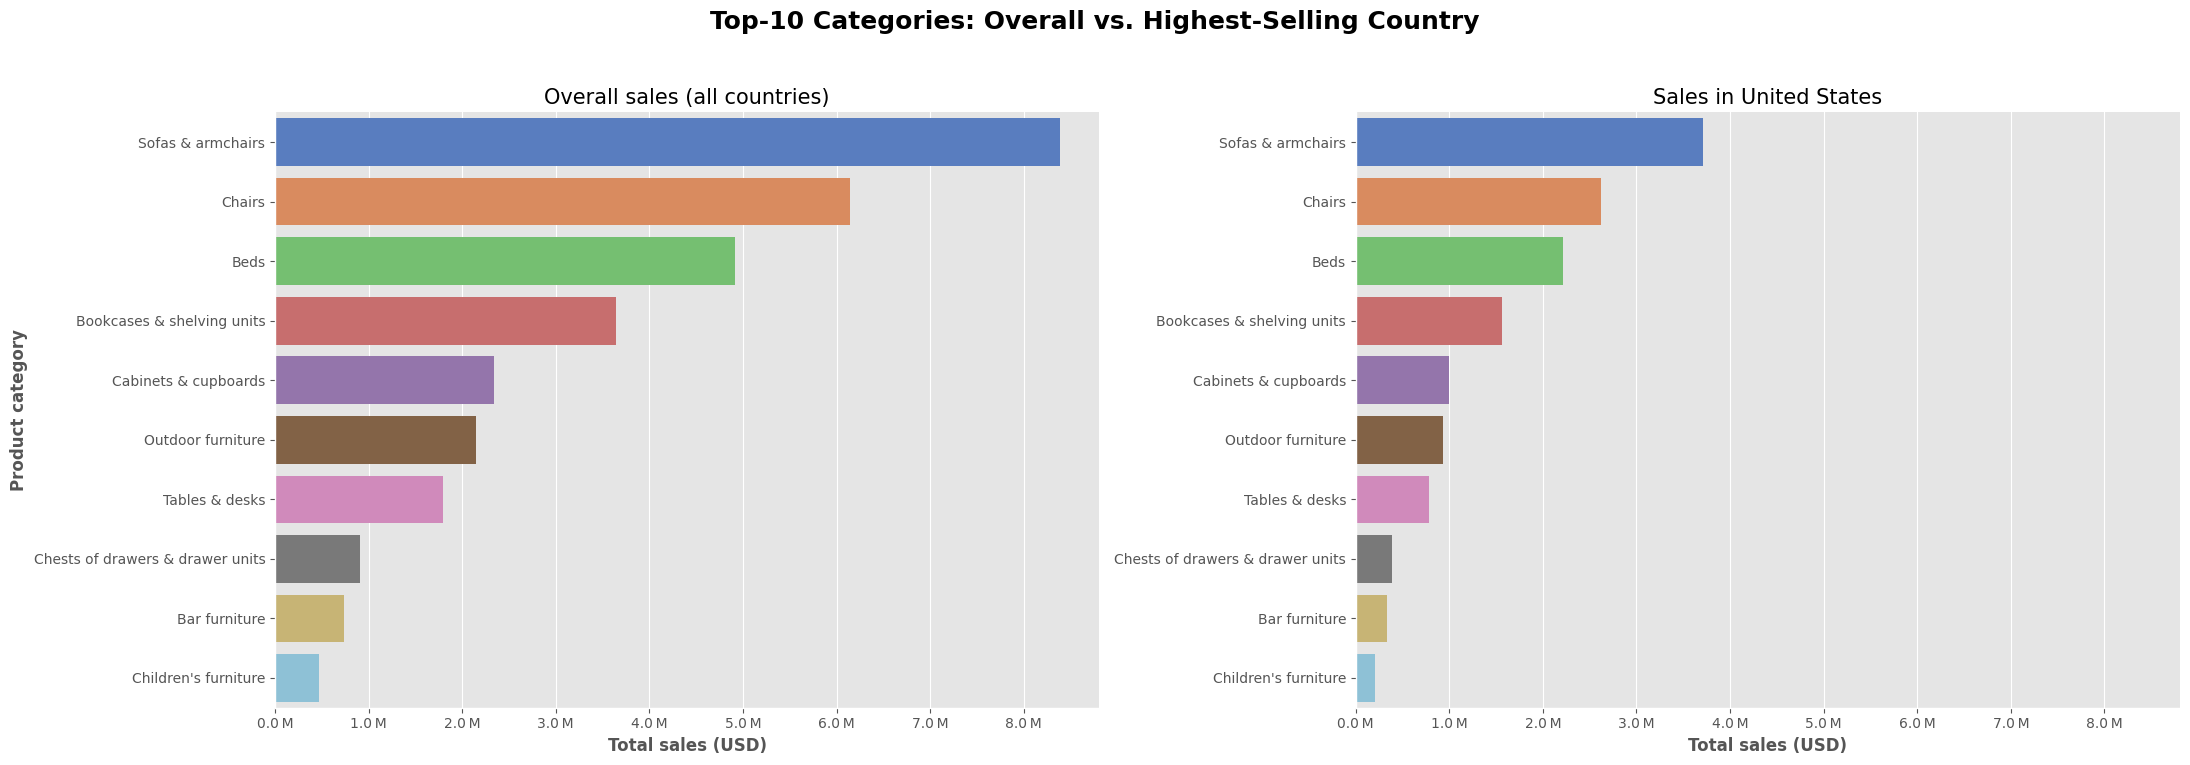

In [16]:
# visual comparison
plt.style.use("ggplot")
palette_overall  = sns.color_palette('muted', len(overall_top10_categories))
palette_country  = sns.color_palette('muted', len(country_top10_categories))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8), sharex=True)
fig.suptitle('Top‑10 Categories: Overall vs. Highest‑Selling Country',
             fontsize=18, weight='bold', y=0.98)

sns.barplot(x=overall_top10_categories.values,
            y=overall_top10_categories.index,
            ax=ax1,
            palette=palette_overall)
ax1.set_title('Overall sales (all countries)', fontsize=15)
ax1.set_xlabel('Total sales (USD)', fontsize=12, weight='bold')
ax1.set_ylabel('Product category', fontsize=12, weight='bold')

sns.barplot(x=country_top10_categories.values,
            y=country_top10_categories.index,
            ax=ax2,
            palette=palette_country)
ax2.set_title(f'Sales in {top_country}', fontsize=15)
ax2.set_xlabel('Total sales (USD)', fontsize=12, weight='bold')
ax2.set_ylabel('')          # y‑axis labels shown on left plot only

# Common axis tweaks
for ax in (ax1, ax2):
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1_000_000:.1f} M'))

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## U.S. Market vs. Global


###**Key Observations**:

- Minimal divergence: The U.S. market strongly reflects global sales trends, showing no significant deviations.

- Identical top-10 composition: The same ten product categories dominate both the global and U.S. rankings. No category is unique to either list.

- Matching order of popularity: The ranking of categories is exactly the same in both cases — with Sofas & Armchairs, Chairs, and Beds consistently leading.

- Substantial revenue share: U.S. sales contribute approximately 42–45% of the global sales across all top categories, underscoring the country’s strategic importance.

### **Business Implications**

- Strategic alignment: Global marketing and merchandising strategies can be confidently extended to the U.S. market. Local adaptation is not critical, as customer preferences are consistent.

- Marketing efficiency: Promotional efforts that succeed globally are highly likely to be effective in the U.S. as well, supporting cost-effective scaling and improved ROI.

- Operational simplicity: The alignment between U.S. and global patterns simplifies demand forecasting, inventory management, and strategic planning.

###**Final Takeaway**

- The U.S. market is not only the company's largest — it's also a reliable reflection of its global customer base. Strategies that perform well globally are almost certain to succeed in the United States.


Sales distribution by device type (as % of total)
device
desktop    59.00
mobile     38.73
tablet      2.26


/tmp/ipython-input-17-1685480397.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


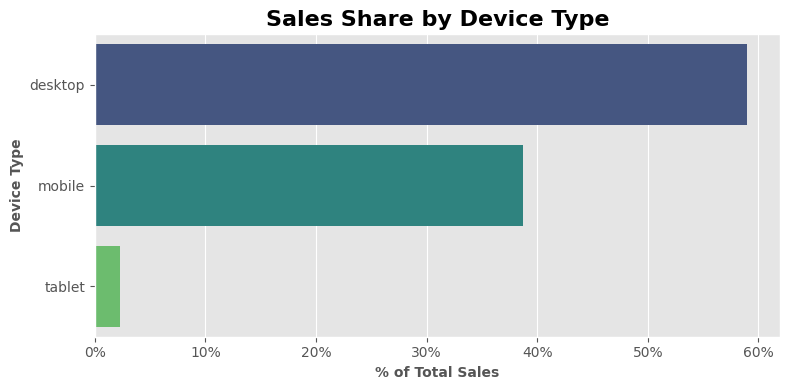

In [17]:
# Sales distribution by device type

total_sales = sales_df["price"].sum()

device_sales = (
    sales_df.groupby("device", as_index=False)["price"]
            .sum()
            .rename(columns={"price": "total_sales"})
            .assign(share=lambda df: df.total_sales / total_sales * 100)
            .sort_values("share", ascending=False)
)

print("\nSales distribution by device type (as % of total)")
print(device_sales.set_index("device")["share"].round(2).to_string())

# visualisation (bar chart)
plt.figure(figsize=(8, 4))
plt.style.use("ggplot")
sns.barplot(
    y=device_sales["device"],
    x=device_sales["share"],
    palette="viridis"
)
plt.title("Sales Share by Device Type", fontsize=16, weight="bold")
plt.xlabel("% of Total Sales", fontsize=10, weight="bold")
plt.ylabel("Device Type", fontsize=10, weight="bold")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))
plt.tight_layout()
plt.show()


Top 10 Mobile Models (% of Mobile Sales)
mobile_model_name
iPhone        51.85
<Other>       46.31
Pixel 4 XL     0.96
Pixel 3        0.88
Safari         0.00
Edge           0.00


/tmp/ipython-input-18-2944420483.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


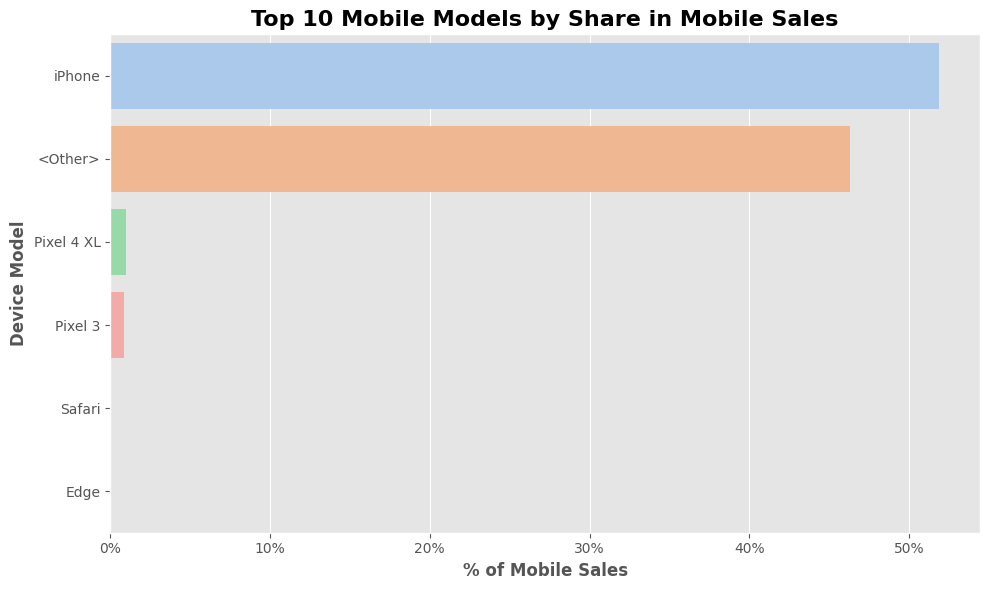

In [18]:
# Sales distribution by mobile models
mobile_df = (
    sales_df.dropna(subset=["mobile_model_name"])
            .query("device == 'mobile'")
)

mobile_total = mobile_df["price"].sum()

top_models = (
    mobile_df.groupby("mobile_model_name", as_index=False)["price"]
             .sum()
             .rename(columns={"price": "model_sales"})
             .sort_values("model_sales", ascending=False)
             .head(10)
             .assign(share=lambda df: df.model_sales / mobile_total * 100)
)

print("\nTop 10 Mobile Models (% of Mobile Sales)")
print(top_models.set_index("mobile_model_name")["share"].round(2).to_string())

plt.figure(figsize=(10, 6))
plt.style.use("ggplot")
sns.barplot(
    x=top_models["share"],
    y=top_models["mobile_model_name"],
    palette="pastel"
)
plt.title("Top 10 Mobile Models by Share in Mobile Sales", fontsize=16, weight="bold")
plt.xlabel("% of Mobile Sales", fontsize=12, weight="bold")
plt.ylabel("Device Model", fontsize=12, weight="bold")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}%"))
plt.tight_layout()
plt.show()



Sales Distribution by Marketing Channel
channel
Organic Search     35.76
Paid Search        26.62
Direct             23.44
Social Search       7.92
Unknown Channel     6.26


/tmp/ipython-input-19-2219578308.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


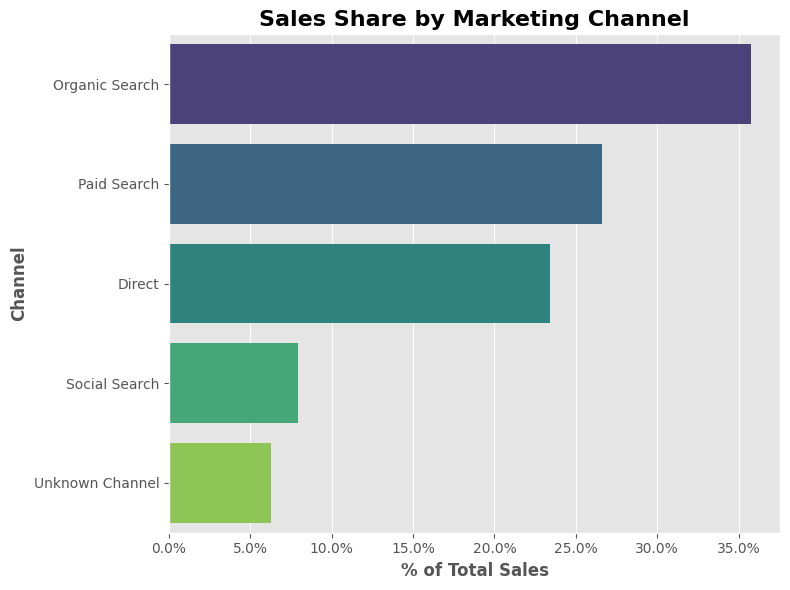

In [19]:
# Sales distribution by marketing channel

# cleaning the channel field
df_cleaned = df.copy()

df_cleaned["channel"] = (df_cleaned["channel"].fillna("Unknown Channel").replace(["Undefined", "", "(data deleted)"], "Unknown Channel"))

# aggregation sales by channel
total_sales = df_cleaned["price"].sum()

channel_sales = (
    df_cleaned.groupby("channel", as_index=False)["price"]
              .sum()
              .rename(columns={"price": "channel_total"})
              .assign(share=lambda d: d["channel_total"] / total_sales * 100)
              .sort_values("share", ascending=False)
)

print("\nSales Distribution by Marketing Channel")
print(channel_sales.set_index("channel")["share"].round(2).to_string())

# visualisation
plt.figure(figsize=(8, 6))
plt.style.use("ggplot")
sns.barplot(
    x=channel_sales["share"],
    y=channel_sales["channel"],
    palette="viridis"
)

plt.title("Sales Share by Marketing Channel", fontsize=16, weight="bold")
plt.xlabel("% of Total Sales", fontsize=12, weight="bold")
plt.ylabel("Channel", fontsize=12, weight="bold")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}%"))
plt.tight_layout()
plt.show()


Sales Distribution by Advertising Medium
medium
organic           34.20
(none)            23.44
referral          17.65
<Other>           14.05
Unknown Medium     6.39
cpc                4.27


/tmp/ipython-input-20-2679515092.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


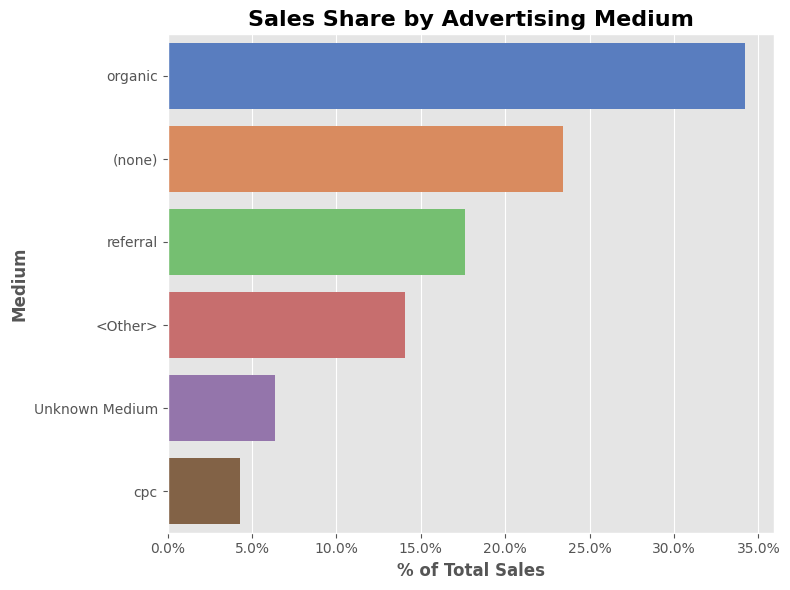

In [20]:
# Sales distribution by advertising medium

# cleaning the medium field (as there are a number of missing values)
df_cleaned = df.copy()

df_cleaned["medium"] = (df_cleaned["medium"].fillna("Unknown Medium").replace(["Undefined", "", "(data deleted)"], "Unknown Medium"))

# aggregation sales by medium
total_sales = df_cleaned["price"].sum()

medium_sales = (
    df_cleaned.groupby("medium", as_index=False)["price"]
              .sum()
              .rename(columns={"price": "medium_total"})
              .assign(share=lambda d: d["medium_total"] / total_sales * 100)
              .sort_values("share", ascending=False)
)

print("\nSales Distribution by Advertising Medium")
print(medium_sales.set_index("medium")["share"].round(2).to_string())

# visualisation
plt.figure(figsize=(8, 6))
plt.style.use("ggplot")
sns.barplot(
    x=medium_sales["share"],
    y=medium_sales["medium"],
    palette="muted"
)
plt.title("Sales Share by Advertising Medium", fontsize=16, weight="bold")
plt.xlabel("% of Total Sales", fontsize=12, weight="bold")
plt.ylabel("Medium", fontsize=12, weight="bold")
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}%"))
plt.tight_layout()
plt.show()

In [21]:
# Top‑selling channel and medium combinations

combo_sales = (
    df_cleaned.groupby(["channel", "medium"], as_index=False)["price"]
            .sum()
            .rename(columns={"price": "combo_total"})
            .sort_values("combo_total", ascending=False)
            .head(10)
            .assign(share=lambda df: df.combo_total / total_sales * 100)
)

print("\nTop‑10 Channel + Medium Combinations (% of total)")
print(
    combo_sales.set_index(["channel", "medium"])["share"]
               .round(2)
               .to_string()
)


Top‑10 Channel + Medium Combinations (% of total)
channel         medium        
Organic Search  organic           31.49
Direct          (none)            23.44
Paid Search     <Other>           14.05
                referral           9.73
Social Search   referral           7.92
Undefined       Unknown Medium     6.26
Organic Search  cpc                4.27
Paid Search     organic            2.72
                Unknown Medium     0.13
Organic Search  <Other>            0.00


##**Key Insights regarding marketing channels and advertising media**:

- **Organic Search is a primary asset**. More than 35% of revenue comes from customers who find company's site via unpaid search results (e.g., Google organic listings).

- **Strong brand and loyal audience**. Almost quarter of sales are driven by Direct traffic (no medium), representing users who already know brand and access site directly by typing the URL or using bookmarks.

- **Paid advertising works but tracking issues exist**. Paid Search is the second most important channel. However, fragmented across different media: <Other>, referral, organic, and unknown medium. This points to tagging or tracking inconsistencies and possible data misattribution., meaning its true effectiveness might be under- or overestimated.

- **Critical analytics misconfiguration detected**. The combination Organic Search + cpc (4.27%) is technically impossible, as cpc (cost per click) tags apply only to paid traffic, not organic. This indicates errors in campaign tagging or tracking setup.

## **User Analysis**

In [22]:
# Preparation of the dataset

# replacing placeholders for missing values
missing_placeholders = ['(not set)', 'None', '<NA>', '(data deleted)', 'NaN', 'NA']

# cleaning key user-related fields
df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
df['is_verified'] = pd.to_numeric(df['is_verified'], errors='coerce')
df['is_unsubscribed'] = pd.to_numeric(df['is_unsubscribed'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['country'] = df['country'].replace(missing_placeholders, pd.NA)

# droping rows without registered account_id
registered_users_df = df.dropna(subset=['user_id']).copy()
unique_accounts_df = registered_users_df.drop_duplicates(subset='user_id')

In [23]:
# --Email verification status among registered users--
total_users = len(unique_accounts_df)
verified_users = unique_accounts_df['is_verified'].sum()
verified_pct = (verified_users / total_users * 100) if total_users > 0 else 0

print("Email Verification Analysis")
print(f"\nTotal Registered Users: {total_users}")
print(f"Verified Emails: {int(verified_users)}")
print(f"Verification Rate: {verified_pct:.2f}%")
# progress bar
print(f"Progress: [{'█' * int(verified_pct / 3)}{'-' * (30 - int(verified_pct / 3))}]")

Email Verification Analysis

Total Registered Users: 27945
Verified Emails: 20036
Verification Rate: 71.70%
Progress: [███████████████████████-------]


In [24]:
# --% of verified users unsubscribed from emails--
unsubscribed_users = unique_accounts_df['is_unsubscribed'].sum()
unsubscribed_pct = (unsubscribed_users / total_users * 100) if total_users > 0 else 0

print("\nUnsubscription Analysis")
print(f"\nUnsubscribed Users: {int(unsubscribed_users)}")
print(f"Unsubscription Rate: {unsubscribed_pct:.2f}%")
# progress bar
print(f"Progress: [{'█' * int(unsubscribed_pct / 3)}{'-' * (30 - int(unsubscribed_pct / 3))}]")


Unsubscription Analysis

Unsubscribed Users: 4735
Unsubscription Rate: 16.94%
Progress: [█████-------------------------]



Avg Order Value (AOV) Comparison
Subscribed Users AOV: $921.51
Unsubscribed Users AOV: $965.82
Difference: -4.59%



/tmp/ipython-input-25-3702866397.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


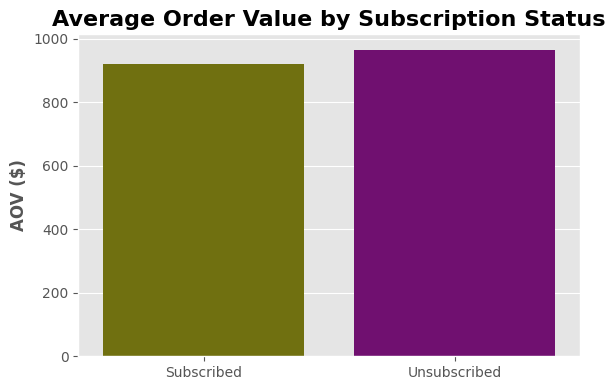

In [25]:
# --Comparison of sales-wise behaviour of subscribed and unsubscribed users--

# preparation of dataset
sales_users_df = df.dropna(subset=['price', 'user_id', 'is_unsubscribed'])
sales_users_df = sales_users_df[sales_users_df['price'] > 0]

# calculation of average order value for subscribed and unsubscribed users
avg_subscribed = sales_users_df[sales_users_df['is_unsubscribed'] == 0]['price'].mean()
avg_unsubscribed = sales_users_df[sales_users_df['is_unsubscribed'] == 1]['price'].mean()

diff_pct = ((avg_subscribed - avg_unsubscribed) / avg_unsubscribed * 100) if avg_unsubscribed > 0 else 0

print("\nAvg Order Value (AOV) Comparison")
print(f"Subscribed Users AOV: ${avg_subscribed:.2f}")
print(f"Unsubscribed Users AOV: ${avg_unsubscribed:.2f}")
print(f"Difference: {diff_pct:.2f}%\n")

# visualisation
plt.figure(figsize=(6, 4))
plt.style.use("ggplot")
sns.barplot(
    x=['Subscribed', 'Unsubscribed'],
    y=[avg_subscribed, avg_unsubscribed],
    palette=['olive', 'purple']
)
plt.title('Average Order Value by Subscription Status', fontsize=16, weight='bold')
plt.ylabel('AOV ($)', fontsize=12, weight="bold")
plt.tight_layout()
plt.show()



Top-10 Countries by Registered Users
country
United States     12384
India              2687
Canada             2067
United Kingdom      859
France              553
Spain               536
Taiwan              500
Germany             490
China               490
Italy               386


/tmp/ipython-input-26-1164511977.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


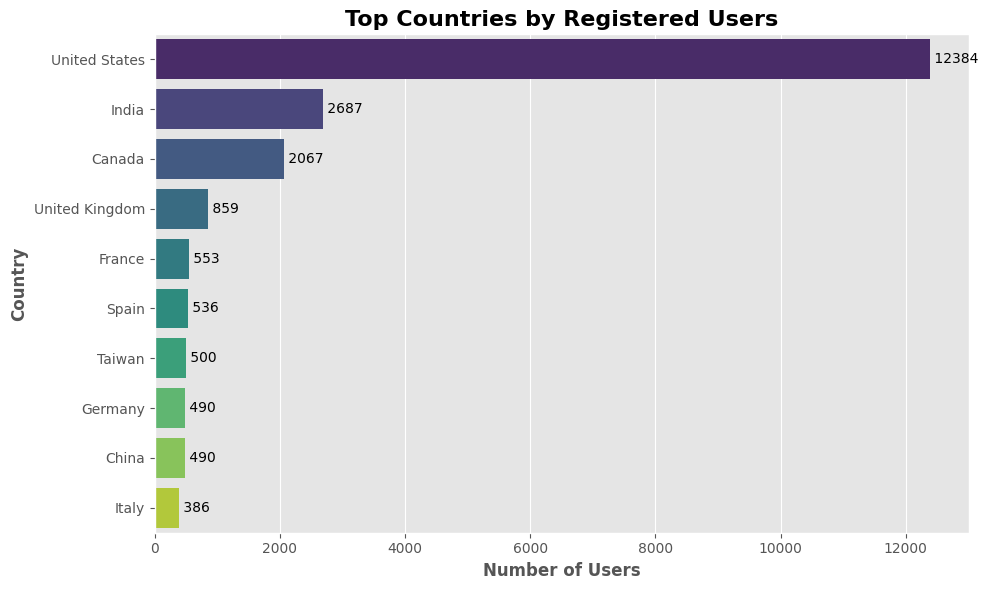

In [26]:
# Top countries by registered users

# preparation of dataset
geo_df = registered_users_df.dropna(subset=['country'])
unique_geo_df = geo_df.drop_duplicates(subset='user_id')

# defining TOP-10 countries
top_countries = unique_geo_df['country'].value_counts().head(10)

print("\nTop-10 Countries by Registered Users")
print(top_countries.to_string())

# visualisation
plt.figure(figsize=(10, 6))
plt.style.use("ggplot")
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top Countries by Registered Users', fontsize=16, weight='bold')
plt.xlabel('Number of Users', fontsize=12, weight="bold")
plt.ylabel('Country', fontsize=12, weight="bold")

for i, value in enumerate(top_countries.values):
    plt.text(value, i, f' {value}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Sales Dynamic Analysis

In [27]:
# Preparation of the dataset

# defining common placeholders representing missing values
missing_placeholders = ['(not set)', 'None', '<NA>', '(data deleted)', 'NaN', 'NA']

# work with a copy to avoid mutating the original DataFrame
df = df.copy()

# converting 'price' to numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# converting 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# replacing invalid values in key categorical columns
for col in ['continent', 'channel', 'device']:
    if col in df.columns:
        df[col] = df[col].replace(missing_placeholders, pd.NA)

# dropping rows missing 'price' or 'date', or where price is 0 or negative
df = df.dropna(subset=['price', 'date'])
df = df[df['price'] > 0]

In [28]:
# Generic plotter function
def plot_pivot(
    data: pd.DataFrame,
    index: str,
    columns: str,
    values: str,
    title: str,
    ylabel: str,
    palette: str = 'viridis',
    smooth: int = 7,
    figsize=(16, 8)
):
    """
    General-purpose line plot using pivoted time-series data.
    Applies rolling average and plots multiple lines with seaborn.
    """
# Pivot to wide format: one column per group (e.g., continent/device/channel)
    pivot = (
        pd.pivot_table(
            data,
            values=values,
            index=index,
            columns=columns,
            aggfunc='sum'
        )
        .fillna(0)
        .rolling(smooth).mean()
    )

# plotting the data
    plt.figure(figsize=figsize)
    sns.set_style("darkgrid")
    pivot.plot(ax=plt.gca(), linewidth=2.2)


# chart formating
    plt.title(title, fontsize=18, weight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(title=columns.capitalize(), fontsize=10)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
    plt.tight_layout()
    plt.show()

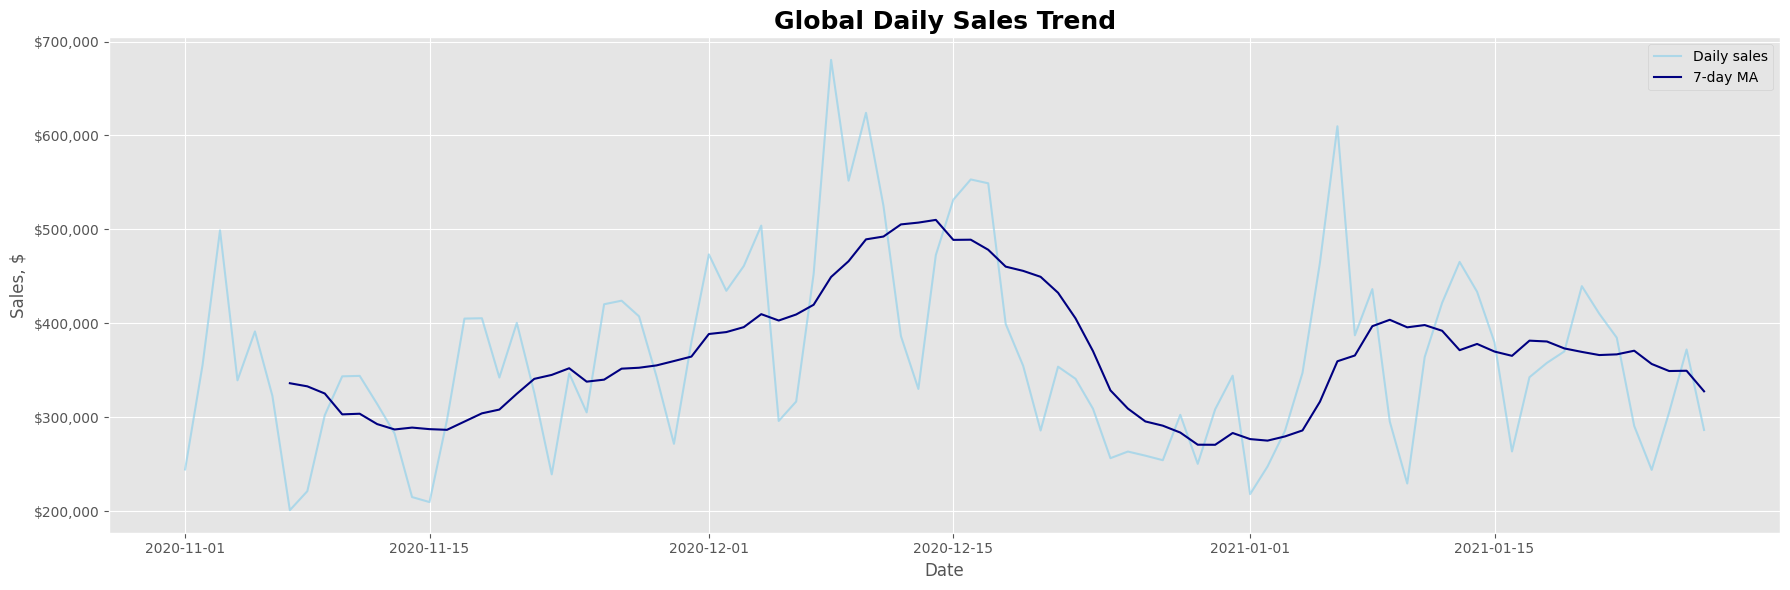

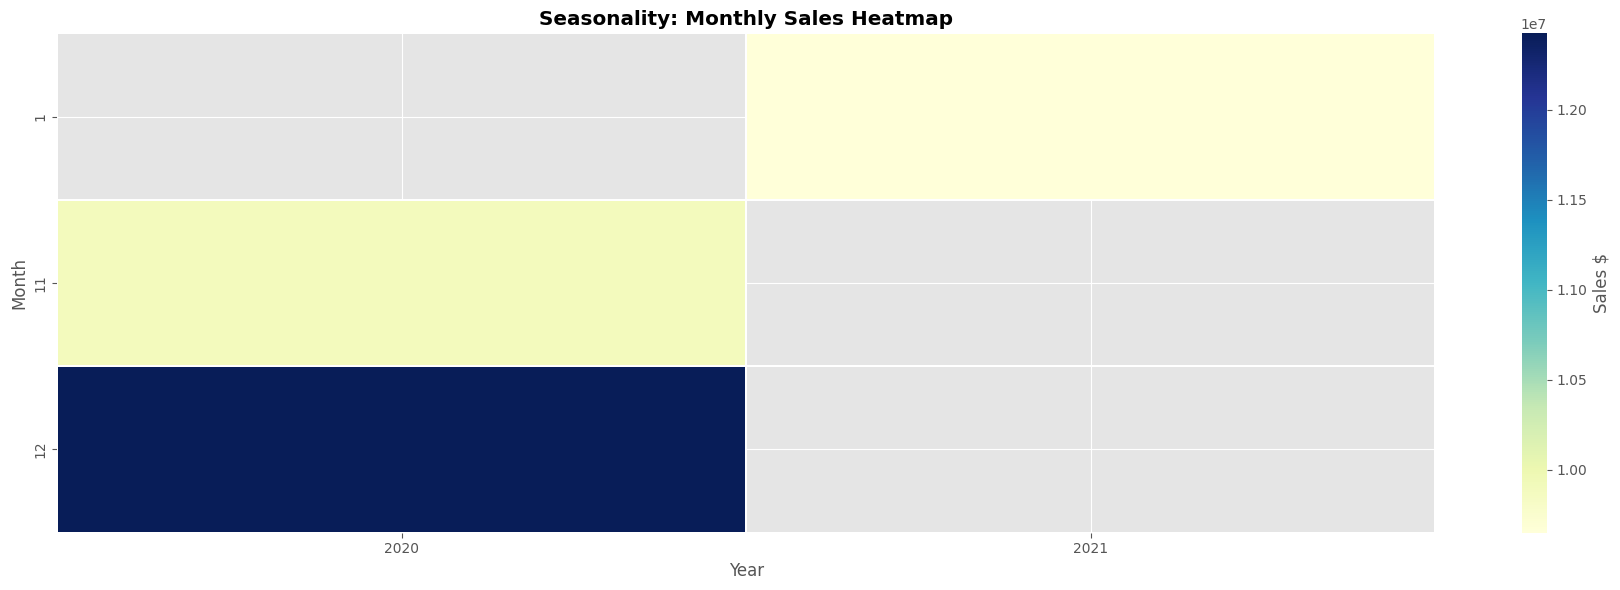

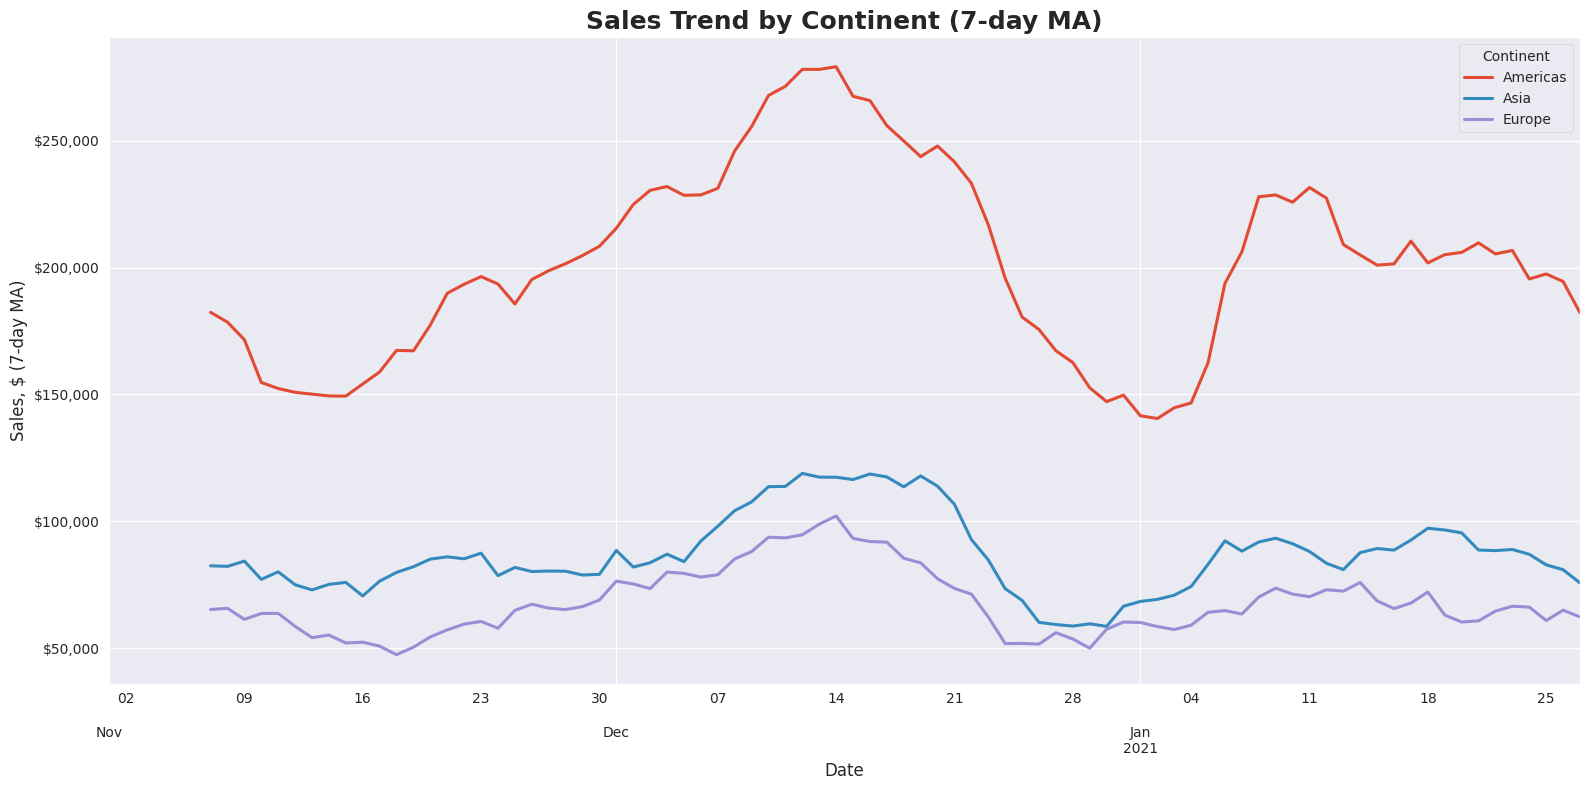

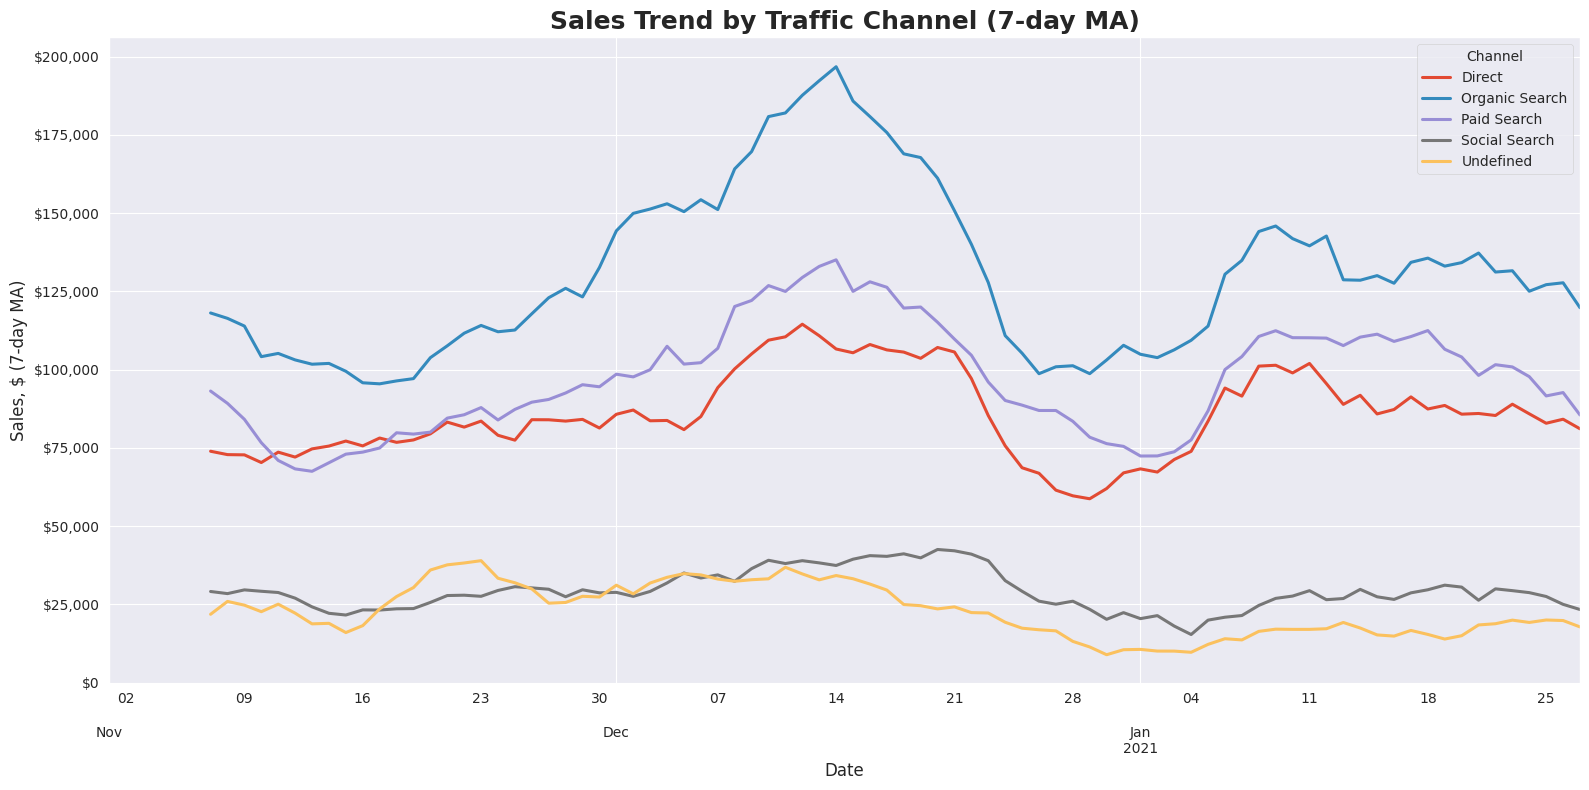

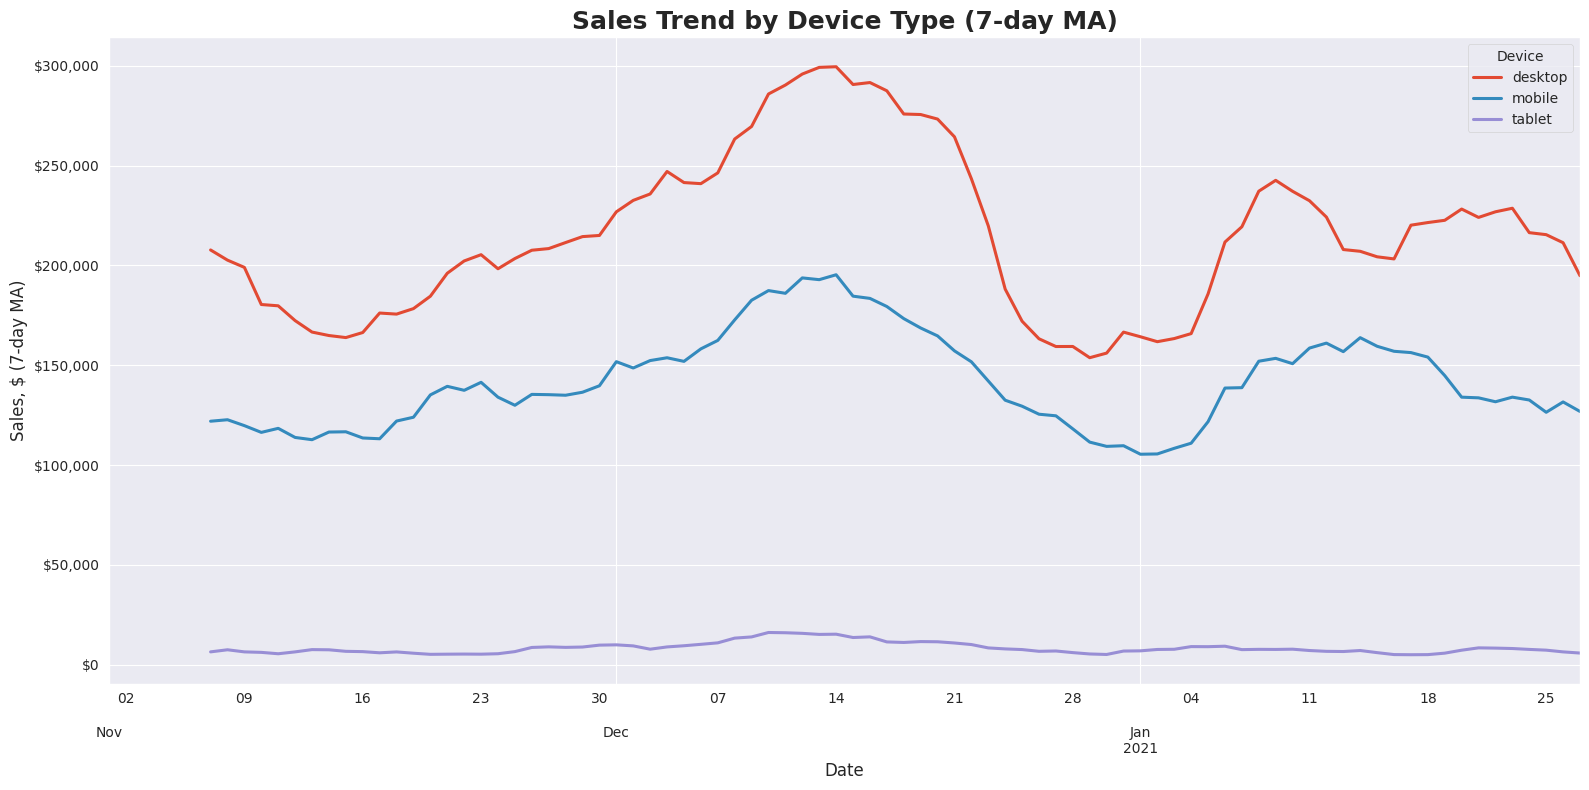

In [29]:
# --Global daily trend--

# grouping sales by day
daily = df.groupby('date')['price'].sum()

# 7-day moving average for smoother trend
ma7   = daily.rolling(7).mean()

# visualisation
plt.figure(figsize=(18, 6))
sns.lineplot(x=daily.index, y=daily.values, label='Daily sales',  color='skyblue', alpha=0.6)
sns.lineplot(x=ma7.index,   y=ma7.values,   label='7‑day MA',    color='navy')
plt.title('Global Daily Sales Trend', fontsize=18, weight='bold')
plt.xlabel('Date'); plt.ylabel('Sales, $')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend(); plt.tight_layout(); plt.show()


# --Seasonability check (month‑of‑year heatmap)--

# creation month-by-year heatmap of total daily sales
month_heat = (
    df.set_index('date')['price']
      .resample('D').sum()
      .groupby([lambda x: x.year, lambda x: x.month]).sum()
      .unstack(level=0)
)

# visualisation of monthly sales patterns across years
plt.figure(figsize=(18, 6))
sns.heatmap(month_heat, cmap='YlGnBu', linewidths=.3, cbar_kws={'label': 'Sales $'})
plt.title('Seasonality: Monthly Sales Heatmap', weight='bold')
plt.xlabel('Year'); plt.ylabel('Month'); plt.tight_layout(); plt.show()


# --Continent-related trends--

# filtering only the most important continents
continents = ['Americas', 'Asia', 'Europe']

# visualisation
plot_pivot(
    data=df[df['continent'].isin(continents)],
    index='date',
    columns='continent',
    values='price',
    title='Sales Trend by Continent (7‑day MA)',
    ylabel='Sales, $ (7‑day MA)',
    palette={'Americas': 'royalblue', 'Asia': 'seagreen', 'Europe': 'darkorange'}
)

# --Channel-related trends--

# identifying TOP-6 channels by total sales
top_channels = (
    df.groupby('channel')['price'].sum()
      .sort_values(ascending=False).head(6).index.tolist()
)

# visualisation
plot_pivot(
    data=df[df['channel'].isin(top_channels)],
    index='date',
    columns='channel',
    values='price',
    title='Sales Trend by Traffic Channel (7‑day MA)',
    ylabel='Sales, $ (7‑day MA)',
    palette='tab10'
)


# --Device-type trends--

# identifying TOP-5 device types
top_devices = (
    df.groupby('device')['price'].sum()
      .sort_values(ascending=False).head(5).index.tolist()
)

# visualisation
plot_pivot(
    data=df[df['device'].isin(top_devices)],
    index='date',
    columns='device',
    values='price',
    title='Sales Trend by Device Type (7‑day MA)',
    ylabel='Sales, $ (7‑day MA)',
    palette='Dark2'
)


## Sessions vs Traffic Channel and Device Type



Pivot Table: Number of sessions by channel and device

device          desktop  mobile  tablet
channel                                
Direct             4655    2985     160
Organic Search     7011    4655     255
Paid Search        5261    3574     207
Social Search      1594    1065      57
Undefined          1181     834      44


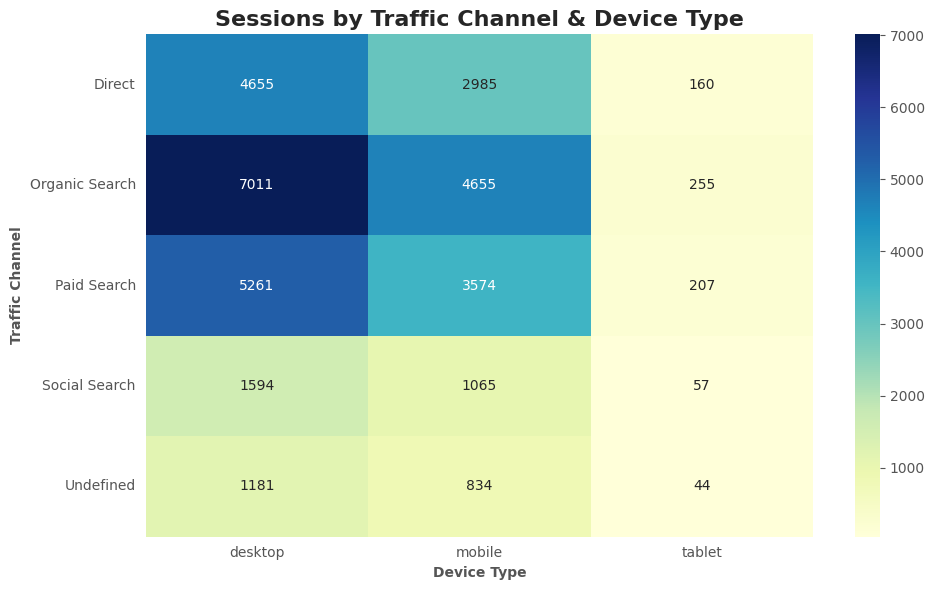

In [30]:
# dropping missing values in relevant columns
df_sessions = df.dropna(subset=['channel', 'device'])

# Pivot table
pivot_sessions = pd.pivot_table(
    df_sessions,
    values='session_id',
    index='channel',
    columns='device',
    aggfunc='count',
    fill_value=0
)

print("Pivot Table: Number of sessions by channel and device\n")
print(pivot_sessions)

# Heatmap visualisation
plt.figure(figsize=(10, 6))
plt.style.use("ggplot")
sns.heatmap(pivot_sessions.astype(int), annot=True, fmt='d', cmap='YlGnBu')
plt.title("Sessions by Traffic Channel & Device Type", fontsize=16, weight='bold')
plt.xlabel("Device Type", fontsize=10, weight='bold')
plt.ylabel("Traffic Channel", fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

## Total sales by product categories and countries


Pivot Table: Total sales by top 10 categories in top 5 countries

country                             Canada    France     India  \
category                                                         
Bar furniture                      51724.0   11199.0   57657.0   
Beds                              354772.0  116414.0  358319.5   
Bookcases & shelving units        278981.9   73830.0  364507.4   
Cabinets & cupboards              181802.0   59101.5  191888.0   
Chairs                            417740.8  134029.4  544309.2   
Chests of drawers & drawer units   71952.0   21544.5   73111.0   
Children's furniture               30264.0   14258.0   39177.0   
Outdoor furniture                 185322.8   40486.4  162289.4   
Sofas & armchairs                 692427.5  187735.0  788430.0   
Tables & desks                    132678.0   42299.0  186157.5   

country                           United Kingdom  United States  
category                                                         
Bar furni

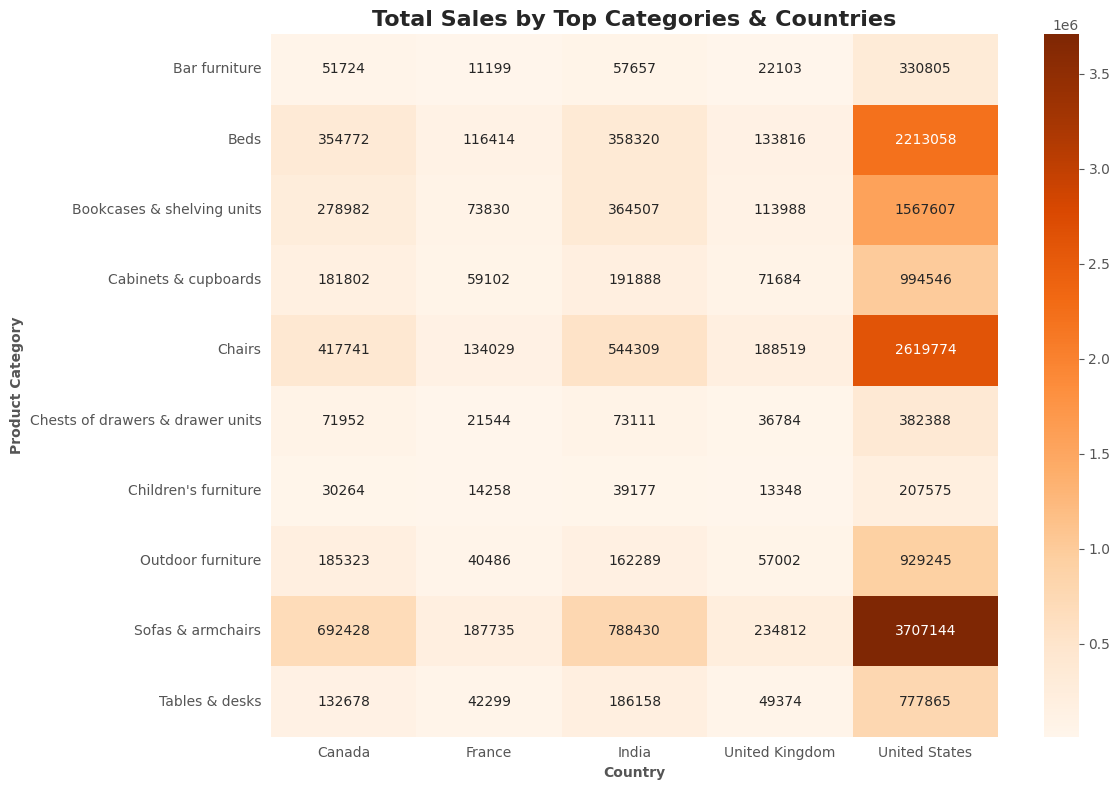

In [31]:
# TOP-10 categories
top_categories = df['category'].value_counts().nlargest(10).index

# TOP-5 countries
top_countries = df['country'].value_counts().nlargest(5).index

# Filtered dataset
df_top = df[df['category'].isin(top_categories) & df['country'].isin(top_countries)]

# Pivot table
pivot_sales = pd.pivot_table(
    df_top,
    values='price',
    index='category',
    columns='country',
    aggfunc='sum',
    fill_value=0
)

print("Pivot Table: Total sales by top 10 categories in top 5 countries\n")
print(pivot_sales)

# Heatmap visualisation
plt.figure(figsize=(12, 8))
plt.style.use("ggplot")
sns.heatmap(pivot_sales, annot=True, fmt='.0f', cmap='Oranges')
plt.title("Total Sales by Top Categories & Countries", fontsize=16, weight='bold')
plt.xlabel("Country", fontsize=10, weight='bold')
plt.ylabel("Product Category", fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

### Unique users by continent and traffic channel


Pivot Table: Unique users by continent and traffic channel

channel    Direct  Organic Search  Paid Search  Social Search  Undefined
continent                                                               
Africa          7              13            4              2          3
Americas      336             562          393            127        114
Asia          154             251          168             55         36
Europe        129             180          132             52         30
Oceania         9              10            8              2          2


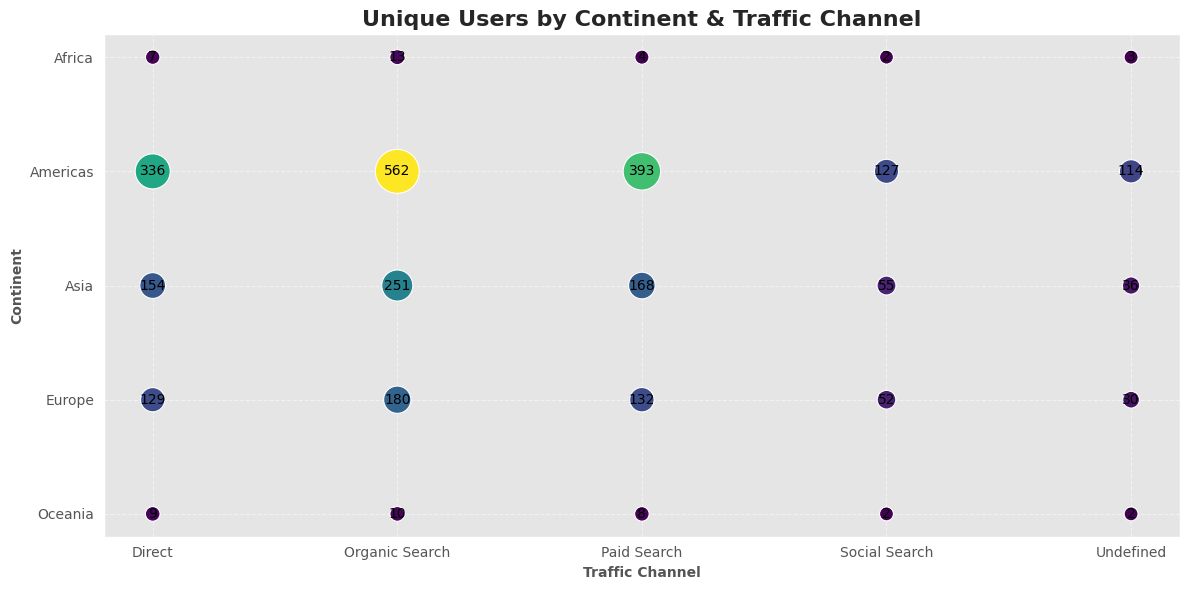

In [32]:
# Preparation of the dataset
df_user_channel = df.dropna(subset=['continent', 'channel', 'user_id'])

# Pivot table
pivot_users = pd.pivot_table(
    df_user_channel,
    values='user_id',
    index='continent',
    columns='channel',
    aggfunc=pd.Series.nunique,
    fill_value=0
)

print("Pivot Table: Unique users by continent and traffic channel\n")
print(pivot_users)

# preparation of data for scatter plot
bubble_data = pivot_users.reset_index().melt(id_vars='continent', var_name='channel', value_name='unique_users')

plt.figure(figsize=(12, 6))
plt.style.use("ggplot")
scatter = sns.scatterplot(
    data=bubble_data,
    x='channel', y='continent',
    size='unique_users', hue='unique_users',
    sizes=(100, 1000), palette='viridis', legend=False
)

# adding data labels to each bubble
for i in range(bubble_data.shape[0]):
    row = bubble_data.iloc[i]
    plt.text(
        row['channel'], row['continent'],
        f"{int(row['unique_users'])}",
        color='black', fontsize=10, ha='center', va='center'
    )

plt.title("Unique Users by Continent & Traffic Channel", fontsize=16, weight='bold')
plt.xlabel("Traffic Channel", fontsize=10, weight='bold')
plt.ylabel("Continent", fontsize=10, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Average order value by device and traffic channel


Pivot Table: Average order value by device and traffic channel

channel  Direct  Organic Search  Paid Search  Social Search  Undefined
device                                                                
desktop  960.82          969.06       946.01         908.02     993.19
mobile   963.26          947.13       931.74         945.27     915.22
tablet   918.73          902.62       985.70        1368.66    1460.20


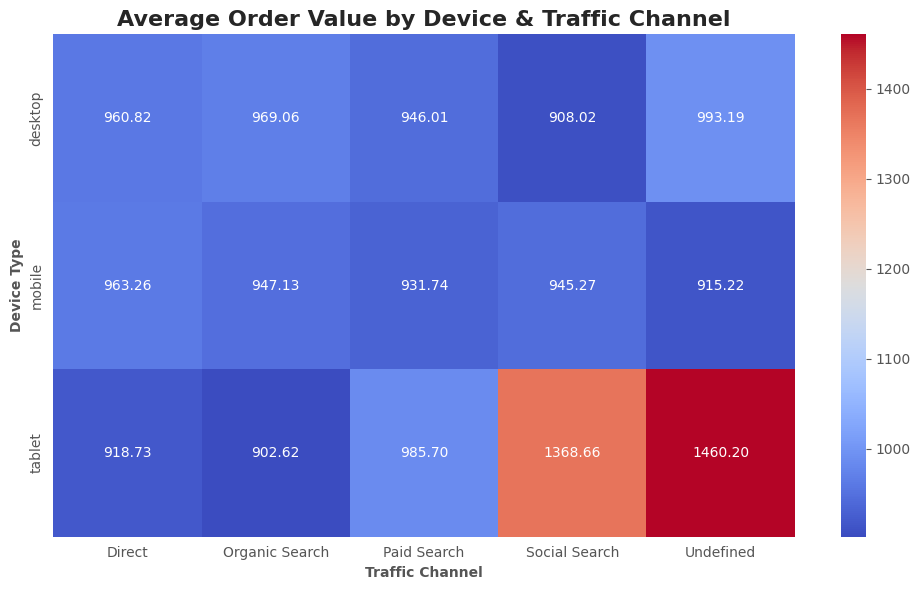

In [33]:
# Preparation of the data
df_avg_check = df.dropna(subset=['device', 'channel'])

# Pivot table
pivot_avg_price = pd.pivot_table(
    df_avg_check,
    values='price',
    index='device',
    columns='channel',
    aggfunc='mean',
    fill_value=0
)

print("Pivot Table: Average order value by device and traffic channel\n")
print(pivot_avg_price.round(2))

# Heatmap visualisation
plt.figure(figsize=(10, 6))
plt.style.use("ggplot")
sns.heatmap(pivot_avg_price, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Average Order Value by Device & Traffic Channel", fontsize=16, weight='bold')
plt.xlabel("Traffic Channel", fontsize=10, weight='bold')
plt.ylabel("Device Type", fontsize=10, weight='bold')
plt.tight_layout()
plt.show()



Correlation: Sessions vs Sales (per day)

Pearson  r = 0.964  | p = 0.0000 → significant
Spearman ρ = 0.951 | p = 0.0000 → significant



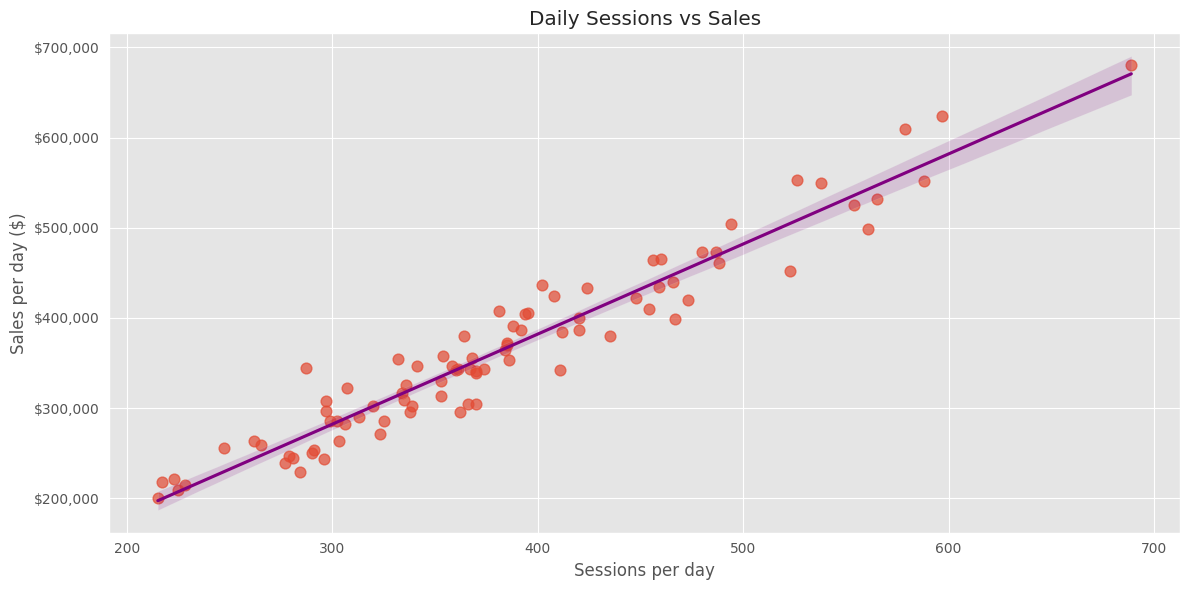

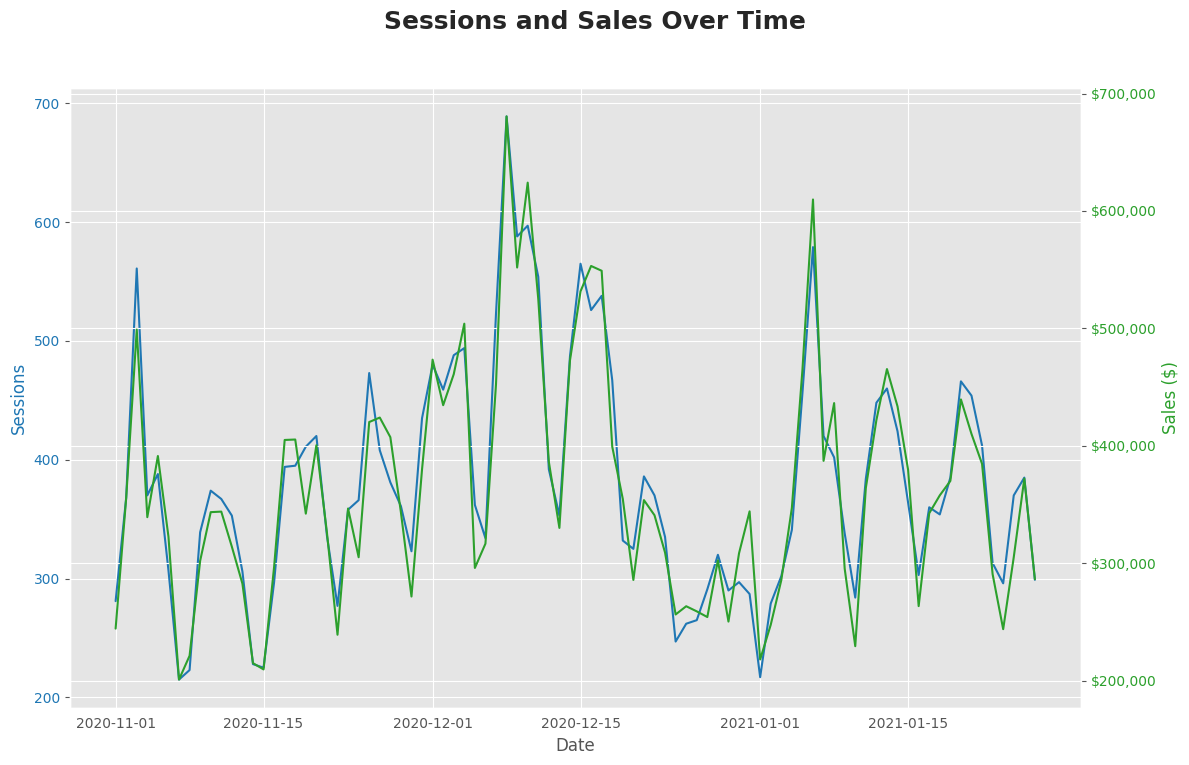

In [34]:
from scipy.stats import pearsonr, spearmanr

# Set Seaborn style for consistent visual formatting
sns.set_style("whitegrid")
plt.style.use("ggplot")

#Cleaning & preparation of daily metrics

# ensuring the dataframe is not modified in-place
df = (
    df.copy()
      # keeping only rows with positive price (valid sales)
      .query("price > 0")
            # removing rows with missing critical values
      .dropna(subset=['price', 'date', 'session_id'])
)

# Aggregation metrics per day:
# - Unique session count per day
# - Total sales amount per day
daily_metrics = (
    df.groupby('date')
      .agg(
          sessions=('session_id', 'nunique'),
          sales=('price', 'sum')
      )
      .sort_index()  # ensuring proper date order
)

# Correlation statistics

# Pearson correlation → linear relationship
pears_r, pears_p = pearsonr(daily_metrics['sessions'], daily_metrics['sales'])

# Spearman correlation → monotonic (rank-based) relationship
spear_r, spear_p = spearmanr(daily_metrics['sessions'], daily_metrics['sales'])

# displaying both correlation coefficients and their significance
print("\nCorrelation: Sessions vs Sales (per day)\n")
print(f"Pearson  r = {pears_r:.3f}  | p = {pears_p:.4f} → {'significant' if pears_p < 0.05 else 'not significant'}")
print(f"Spearman ρ = {spear_r:.3f} | p = {spear_p:.4f} → {'significant' if spear_p < 0.05 else 'not significant'}\n")

# Scatter plot + regression line

plt.figure(figsize=(12, 6))
ax = sns.regplot(
    data=daily_metrics,
    x='sessions', y='sales',
    line_kws={'color': 'purple'},         # regression line color
    scatter_kws={'alpha': .7, 's': 60}     # control point size and transparency
)

# setting axis labels and title
ax.set(
    title='Daily Sessions vs Sales',
    xlabel='Sessions per day',
    ylabel='Sales per day ($)'
)

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Dual-axis time series plot (Sessions & Sales over time)

fig, ax1 = plt.subplots(figsize=(12, 8))

# First axis for sessions (left)
color1 = 'tab:blue'
ax1.plot(daily_metrics.index, daily_metrics['sessions'],
         color=color1, label='Sessions')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Sessions', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Second axis for sales (right), sharing x-axis
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.plot(daily_metrics.index, daily_metrics['sales'],
         color=color2, label='Sales')
ax2.set_ylabel('Sales ($)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Format y-axis as currency
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Overall title and layout adjustments
fig.suptitle('Sessions and Sales Over Time', fontsize=18, weight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Interpretation of Results:**

- An exceptionally strong positive linear relationship (Pearson r = 0.964). Days with higher traffic almost invariably generate higher revenue; the association is near‑perfect.
- Spearman  ρ (=0.951) confirms a very strong monotonic relationship: as session counts rise, sales rise in the same rank order, even if the escalation is not perfectly linear.
- p‑value (both tests)	< 0.0001 is well below the 0.05 threshold, indicating the observed correlations are highly unlikely to be due to chance. The relationship is statistically significant.
- Scatter plot with regression line points representing individual days align tightly along an upward‑sloping line, visually reinforcing the near‑perfect positive correlation.
- In dual‑axis time‑series plot the “pulse” of traffic (blue line) and the “pulse” of revenue (green line) move in near lockstep. Peaks and troughs coincide across the two series, underscoring that fluctuations in daily sessions directly drive fluctuations in daily sales.

**Practical takeaway:**
Traffic volume is a powerful and reliable predictor of daily revenue. Marketing efforts that boost session counts can be expected to translate almost proportionally into higher sales.

TOP‑3 continents selected: ['Americas', 'Asia', 'Europe']

Correlation matrix (Pearson r):
continent  Americas   Asia  Europe
continent                         
Americas      1.000  0.692   0.670
Asia          0.692  1.000   0.668
Europe        0.670  0.668   1.000

P‑value matrix:
continent  Americas  Asia  Europe
continent                        
Americas        1.0   0.0     0.0
Asia            0.0   1.0     0.0
Europe          0.0   0.0     1.0


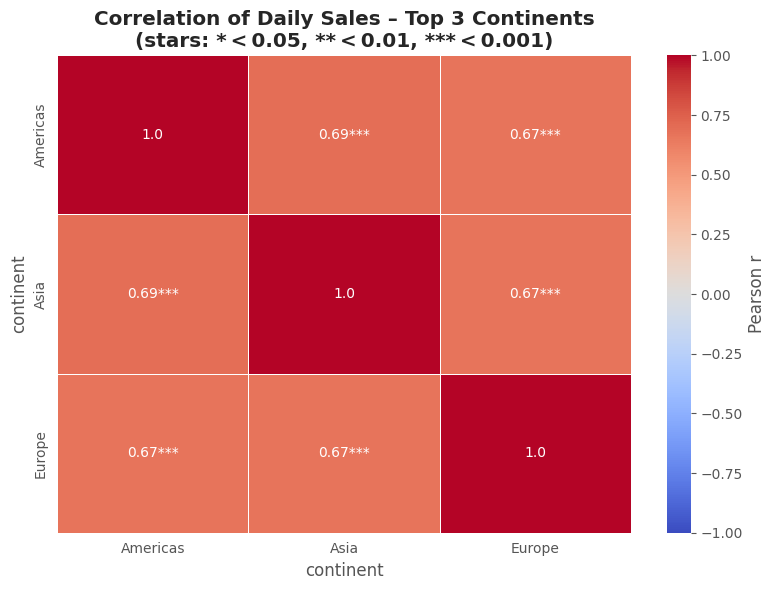

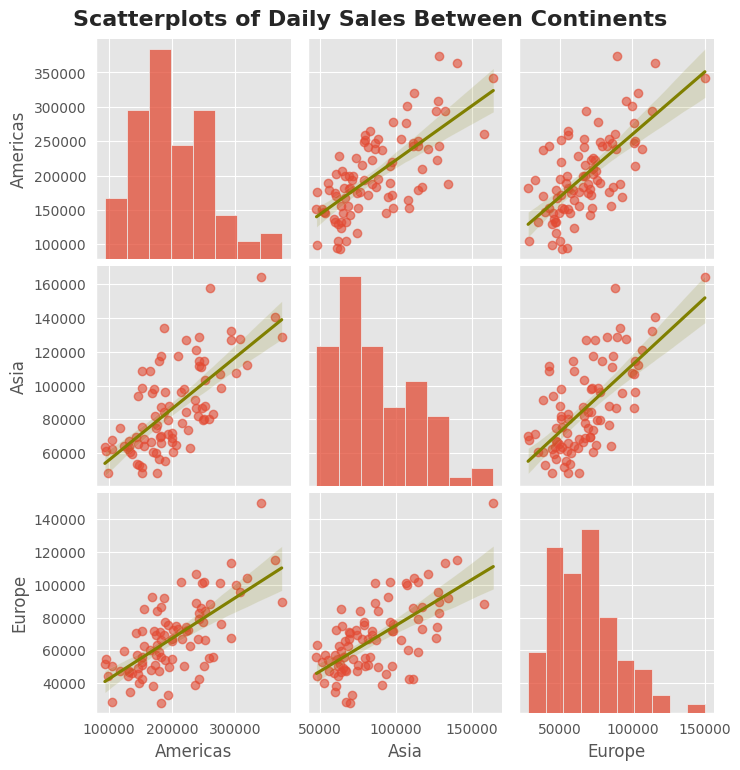

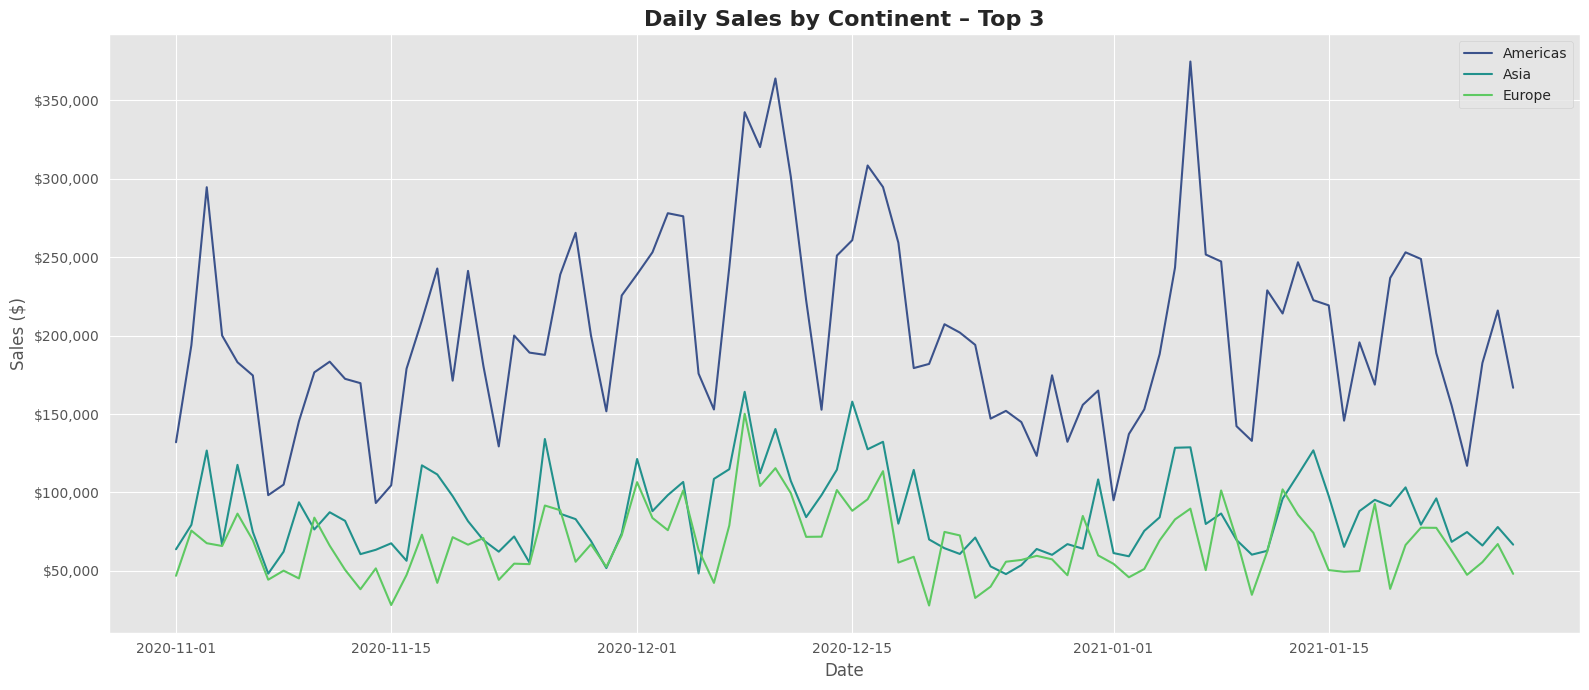

In [35]:
# Correlation of sales across the top‑3 continents

from itertools import combinations

plt.style.use("ggplot")

# data cleaning & preparation
df = (
    df.copy()
      .replace({'continent': missing_placeholders})
      .query("price > 0")
      .dropna(subset=['price', 'continent'])
)

# Identifying TOP‑3 continents by total sales
top3_continents = (
    df.groupby('continent')['price']
      .sum()
      .nlargest(3)
      .index
      .tolist()
)
print(f"TOP‑3 continents selected: {top3_continents}")

# building daily sales pivot (wide format)
daily_cont_sales = (
    df[df['continent'].isin(top3_continents)]
      .pivot_table(index='date', columns='continent', values='price', aggfunc='sum')
      .fillna(0)
      .sort_index()
)

# correlation & p‑value matrix
def corr_pvals(df_wide):
    cols = df_wide.columns
    r = pd.DataFrame(np.eye(len(cols)), columns=cols, index=cols)
    p = r.copy()

    for c1, c2 in combinations(cols, 2):
        coef, pv = pearsonr(df_wide[c1], df_wide[c2])
        r.loc[c1, c2] = r.loc[c2, c1] = coef
        p.loc[c1, c2] = p.loc[c2, c1] = pv

    return r, p

corr, pvals = corr_pvals(daily_cont_sales)

print("\nCorrelation matrix (Pearson r):")
print(corr.round(3))
print("\nP‑value matrix:")
print(pvals.round(4))

# Heatmap with significance stars
def star_sig(p):
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return ''

annot = corr.round(2).astype(str)
for i in range(len(corr)):
    for j in range(len(corr)):
        if i != j:
            annot.iloc[i, j] += star_sig(pvals.iloc[i, j])

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr, annot=annot, fmt='', cmap='coolwarm',
    vmin=-1, vmax=1, linewidths=.5,
    cbar_kws={'label': 'Pearson r'}
)
plt.title('Correlation of Daily Sales – Top 3 Continents\n'
          '(stars: * < 0.05, ** < 0.01, *** < 0.001)', weight='bold')
plt.tight_layout()
plt.show()

# Pairplot with regression lines
sns.pairplot(
    daily_cont_sales,
    kind='reg',
    plot_kws={'line_kws': {'color': 'olive'}, 'scatter_kws': {'alpha': .6}}
)
plt.suptitle('Scatterplots of Daily Sales Between Continents', y=1.02, fontsize=16, weight='bold')
plt.show()

# Time‑series overlay for quick visual check
plt.figure(figsize=(16, 7))
palette = dict(zip(top3_continents, sns.color_palette('viridis', len(top3_continents))))
for cont in top3_continents:
    plt.plot(daily_cont_sales.index, daily_cont_sales[cont],
             label=cont, color=palette[cont])

plt.title('Daily Sales by Continent – Top 3', fontsize=16, weight='bold')
plt.xlabel('Date'); plt.ylabel('Sales ($)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
plt.tight_layout()
plt.show()


### **Interpretation of results:**

**Key findings:**
- Strength of association: All cross‑continent coefficients sit in the 0.65–0.70 range, which is generally classified as strong positive correlation. In practical terms, a sales upswing on one continent is very likely to coincide with an upswing on the other two.
- Statistical significance: p‑values are effectively zero (< 0.05) for every pair, confirming that these correlations are highly significant and not due to chance.
- Heatmap: every off‑diagonal cell appears in a warm colour, reinforcing the strength of the positive links.
- Scatter (pairplot): daily data points cluster tightly around upward‑sloping regression lines, graphically illustrating the same pattern.

**Practical takeaway:**
- Global sync: The three key regions move almost in unison, suggesting that macro‑level factors (e.g., worldwide marketing pushes or seasonality) are driving sales across markets simultaneously.
- Leverage shared campaigns: Company‑wide promotions or product launches are likely to lift revenue on all three continents at once.
- Watch for local nuances: Correlations are strong but not perfect; retain some regional flexibility to capture continent‑specific opportunities or mitigate local downturns.

*Sales performance behaves as a coordinated global system: when one continent accelerates, the others accelerate too, and the evidence is both statistically robust and visually clear.*

TOP-6 channels selected for analysis:
['Organic Search', 'Paid Search', 'Direct', 'Social Search', 'Undefined']

Spearman Correlation Matrix

channel         Direct  Organic Search  Paid Search  Social Search  Undefined
channel                                                                      
Direct           1.000           0.753        0.693          0.400      0.497
Organic Search   0.753           1.000        0.765          0.385      0.458
Paid Search      0.693           0.765        1.000          0.420      0.487
Social Search    0.400           0.385        0.420          1.000      0.382
Undefined        0.497           0.458        0.487          0.382      1.000 

P-value Matrix

channel         Direct  Organic Search  Paid Search  Social Search  Undefined
channel                                                                      
Direct          0.0000          0.0000          0.0         0.0001     0.0000
Organic Search  0.0000          0.0000          0.0         

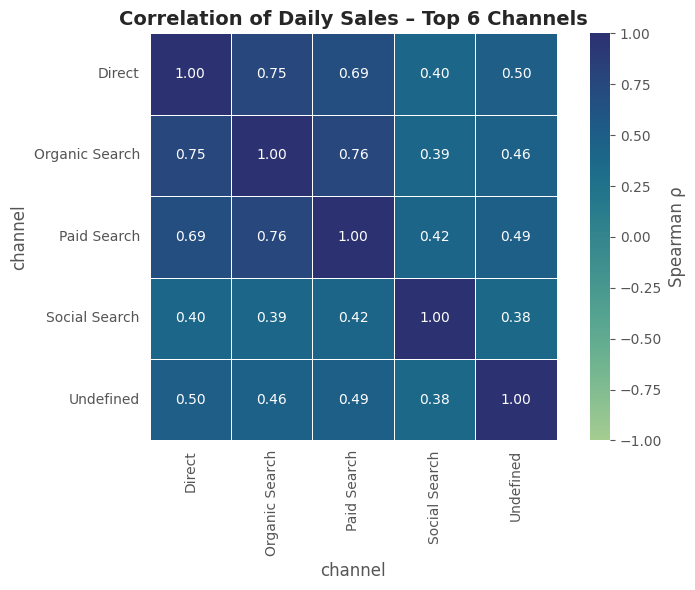


Scatter Plot Matrix


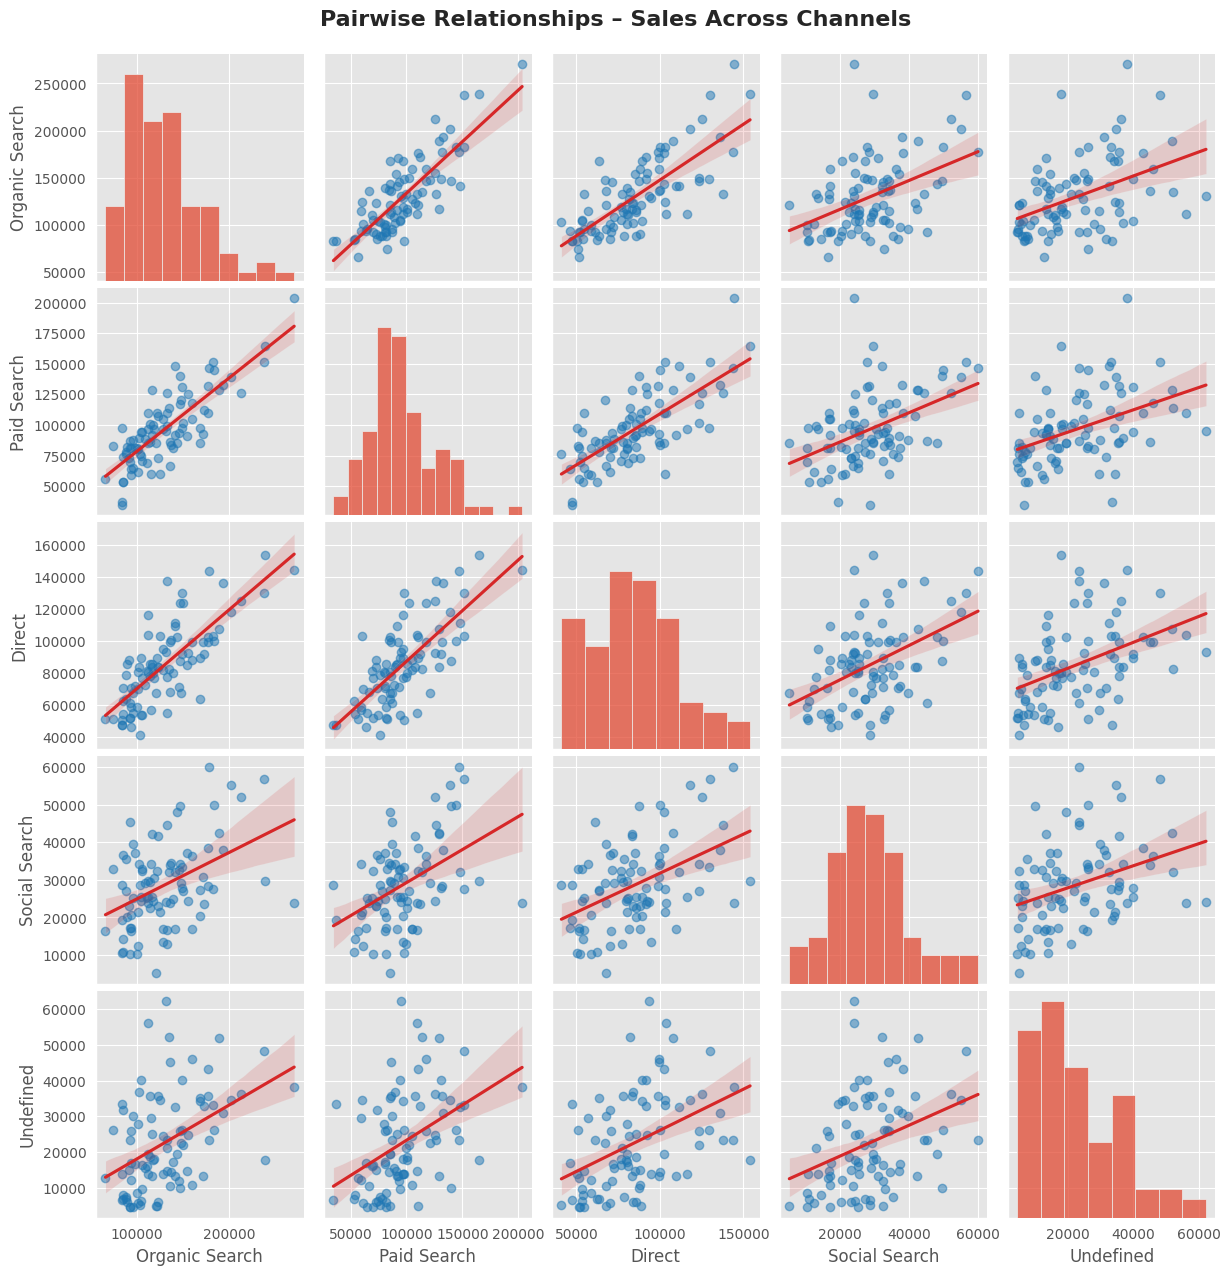

In [36]:
# Correlation of sales across traffic channels
plt.style.use("ggplot")

# data cleaning & preparation
df = (
    df.copy()
      .replace({'channel': missing_placeholders})
      .query("price > 0")
      .dropna(subset=['price', 'channel'])
)

# Identifying TOP channels by total sales
top_channels = (
    df.groupby('channel')['price']
      .sum()
      .sort_values(ascending=False)
      .head(6)
      .index
      .tolist()
)

print(f"TOP-6 channels selected for analysis:\n{top_channels}\n")

# Computing correlation and p-value matrices
def corr_pval_matrix(df, method='pearson'):
    cols = df.columns
    n = len(cols)
    corr = pd.DataFrame(index=cols, columns=cols, dtype=float)
    pval = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i in range(n):
        for j in range(n):
            if method == 'spearman':
                r, p = spearmanr(df[cols[i]], df[cols[j]])
            else:
                r, p = pearsonr(df[cols[i]], df[cols[j]])
            corr.iloc[i, j] = r
            pval.iloc[i, j] = p

    return corr, pval


# Daily pivot table
chan_daily = (
    df[df['channel'].isin(top_channels)]
      .pivot_table(index='date', columns='channel', values='price', aggfunc='sum')
      .fillna(0)
)

# Correlation & P-values
corr_matrix, pval_matrix = corr_pval_matrix(chan_daily, method="spearman")

print(f"Spearman Correlation Matrix\n")
print(corr_matrix.round(3), '\n')

print(f"P-value Matrix\n")
print(pval_matrix.round(4), '\n')

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='crest',
    vmin=-1, vmax=1,
    cbar_kws={'label': 'Spearman ρ'},
    linewidths=0.5,
    square=True
)
plt.title('Correlation of Daily Sales – Top 6 Channels', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

# Scatter plots (pairplot)
print("\nScatter Plot Matrix")
sns.pairplot(
    chan_daily[top_channels],
    kind='reg',
    plot_kws={'line_kws': {'color': '#d62728'}, 'scatter_kws': {'alpha': 0.5, 'color': '#1f77b4'}}
)
plt.suptitle('Pairwise Relationships – Sales Across Channels', y=1.02, fontsize=16, weight='bold')
plt.show()


### **Interpretation of results:**
**Key findings:**
1. Correlation Matrix (Spearman ρ):
- Direct & Organic Search	demonstrate strong positive correlation (ρ = 0.753) — when sales rise via one, they likely rise via the other.
- Organic & Paid Search	have strongest relationship (ρ = 0.765) — highly synchronized search-driven sales.
- Direct & Paid Search	also demonstrate a strong correlation (ρ = 0.693) — people converting through direct and paid ads tend to follow similar patterns.
- Social Search has moderate to weak correlation (ρ = 0.38–0.42) with other traditional channels, which is expected for socially driven traffic.
- Undefined channel	has a moderate correlation with the rest (ρ = 0.46–0.50),  possibly due to a mix of sources or attribution gaps.

**Takeaway:** Sales across search-related channels (organic, paid) and direct visits are strongly interlinked. If one performs well, the others often do too. Meanwhile, Social Search behaves more independently, which aligns with its distinct behavior and influence patterns.

2. P-Value Matrix:

- All correlations are statistically significant with p-values < 0.001, meaning the probability that observed relationships occurred by random chance is virtually zero. These correlations are valid and reliable.

3. Scatter Plot Matrix (Pairplot):

The scatter plots with regression lines offer visual proof of these relationships:

- Tight clusters along upward-sloping lines for pairs like Paid Search vs Organic Search confirm their strong monotonic relationship.
- More dispersed plots (e.g., Social Search vs Direct) show weaker, noisier associations.

**Takeaway**: This visual check aligns with the numerical findings — channels like Social Search are less predictable, while Paid and Organic are closely tied.

**Practical takeaways:**
- Search and direct channels form a tightly connected sales ecosystem. Their daily performance moves in sync, which suggests unified user intent or campaign synergy.
- Social Search operates more independently — offering unique opportunities for diversification or viral reach, but less predictable alignment with other channels.
- The Undefined group’s moderate correlation implies it may include traffic types similar to others, but with attribution issues.

Top‑5 categories selected: ['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards']

Pearson Correlation Matrix
category                     Beds  Bookcases & shelving units  \
category                                                        
Beds                        1.000                       0.594   
Bookcases & shelving units  0.594                       1.000   
Cabinets & cupboards        0.516                       0.537   
Chairs                      0.557                       0.640   
Sofas & armchairs           0.531                       0.663   

category                    Cabinets & cupboards  Chairs  Sofas & armchairs  
category                                                                     
Beds                                       0.516   0.557              0.531  
Bookcases & shelving units                 0.537   0.640              0.663  
Cabinets & cupboards                       1.000   0.575              0.664  
Chair

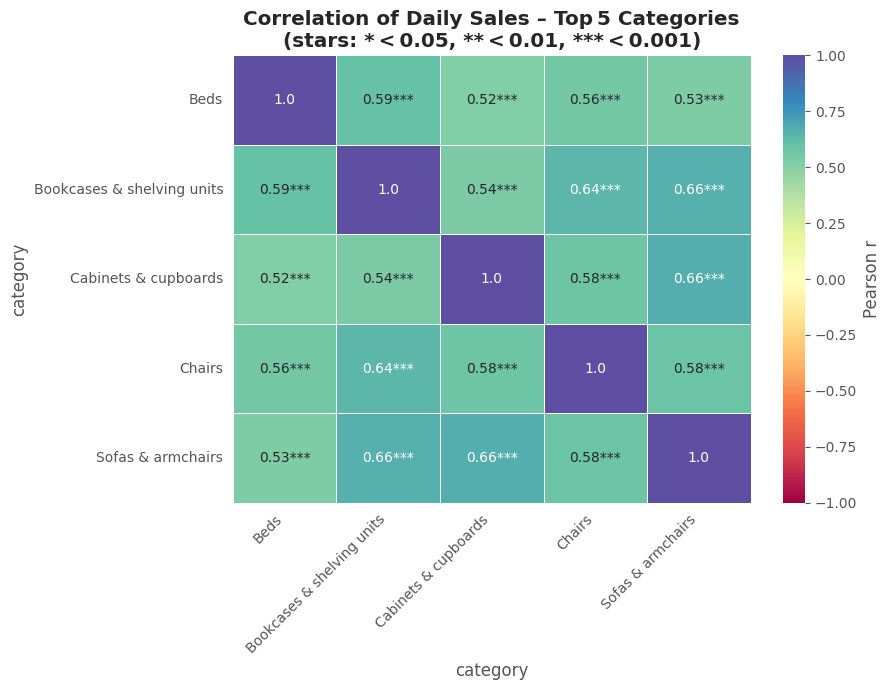


Scatter Plot Matrix


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill

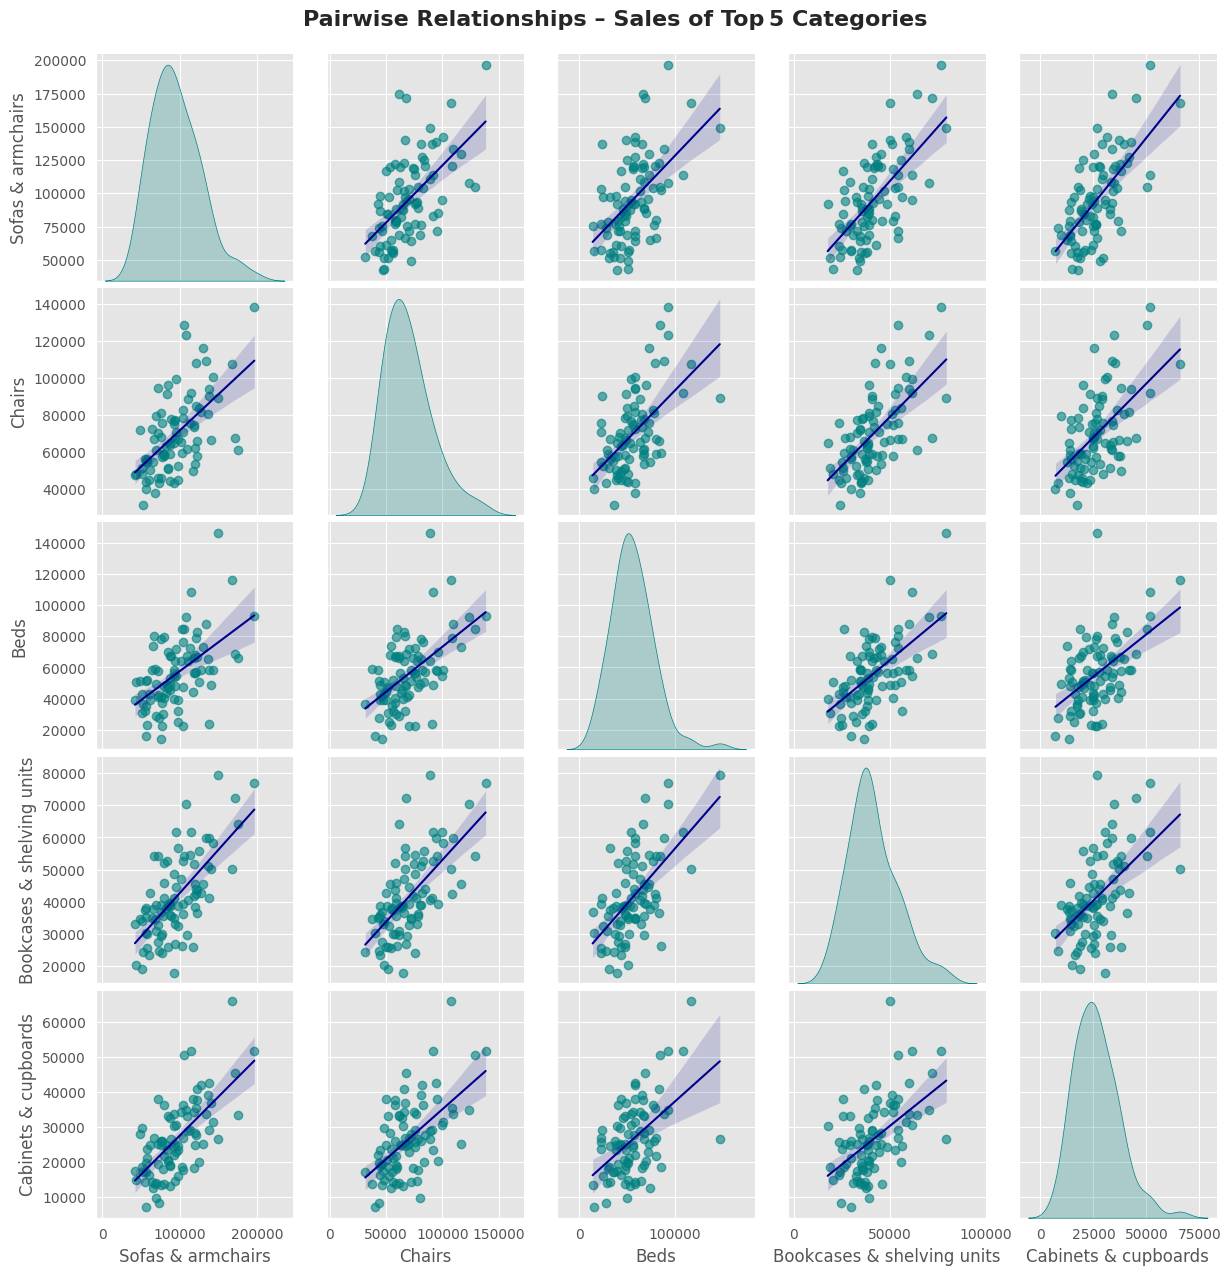

In [37]:
# Correlation of sales across TOP‑5 product categories
# data cleaning & preparation
df = (
    df.copy()
      .replace({'category': missing_placeholders})
      .query("price > 0")
      .dropna(subset=['price', 'category'])
)

# Identifying TOP-5 product categories by total sales
top5_cats = (
    df.groupby('category')['price'].sum()
      .sort_values(ascending=False).head(5).index.tolist()
)

print(f"Top‑5 categories selected: {top5_cats}\n")

# Pivot daily sales by category
cat_daily = (
    df[df['category'].isin(top5_cats)]
      .pivot_table(index='date', columns='category', values='price', aggfunc='sum')
      .fillna(0)
)

# Correlation + p‑value matrices
def corr_pval_matrix(df_wide, method="pearson"):
    cols = df_wide.columns
    r = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols)
    p = pd.DataFrame(np.zeros_like(r), index=cols, columns=cols)

    for c1, c2 in combinations(cols, 2):
        if method == "spearman":
            coef, pv = spearmanr(df_wide[c1], df_wide[c2])
        else:
            coef, pv = pearsonr(df_wide[c1], df_wide[c2])
        r.loc[c1, c2] = r.loc[c2, c1] = coef
        p.loc[c1, c2] = p.loc[c2, c1] = pv

    return r.astype(float), p.astype(float)

# Correlation analysis
corr_pear, p_pear = corr_pval_matrix(cat_daily, method="pearson")
corr_spear, p_spear = corr_pval_matrix(cat_daily, method="spearman")

print("Pearson Correlation Matrix")
print(corr_pear.round(3), "\n")

print("Pearson P‑value Matrix")
print(p_pear.round(4), "\n")

print("Spearman Correlation Matrix")
print(corr_spear.round(3), "\n")

print("Spearman P‑value Matrix")
print(p_spear.round(4), "\n")

# Quick textual significance report
print("Significance Report (Pearson)")
for c1, c2 in combinations(top5_cats, 2):
    r = corr_pear.loc[c1, c2]
    p = p_pear.loc[c1, c2]
    strength = "strong" if abs(r) >= .7 else "moderate" if abs(r) >= .5 else "weak"
    sig = "significant" if p < 0.05 else "not significant"
    print(f"{c1} ↔ {c2}: r = {r:.3f} ({strength}, {sig}, p={p:.4f})")
print()

# Heatmap with significance stars (Pearson shown)
def star(p):      # significance stars
    return '***' if p < .001 else '**' if p < .01 else '*' if p < .05 else ''

annot = corr_pear.round(2).astype(str)
for i in range(len(top5_cats)):
    for j in range(len(top5_cats)):
        if i != j:
            annot.iloc[i, j] += star(p_pear.iloc[i, j])

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr_pear,
    annot=annot, fmt='', cmap='Spectral', vmin=-1, vmax=1,
    linewidths=.5, cbar_kws={'label': 'Pearson r'}
)
plt.title('Correlation of Daily Sales – Top 5 Categories\n'
          '(stars: * < 0.05, ** < 0.01, *** < 0.001)', weight='bold')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Pairplot
plt.style.use("ggplot")

print("\nScatter Plot Matrix")
sns.pairplot(
    cat_daily[top5_cats],
    kind='reg',
    diag_kind='kde',
    palette='coolwarm',
    plot_kws={
        'line_kws': {'color': 'darkblue', 'linewidth': 1.5},
        'scatter_kws': {'alpha': 0.6, 'color': 'teal'}
    },
    diag_kws={'shade': True, 'color': 'teal'}
)

plt.suptitle('Pairwise Relationships – Sales of Top 5 Categories',
             y=1.02, fontsize=16, weight='bold')
plt.show()


### **Interpretation of Results:**
**Key findings:**
1. All pairwise correlations among the top 5 product categories are positive, moderate in strength, and statistically significant.
2. Pearson Correlation (Linear Relationships):
- All Pearson r values fall between 0.516 and 0.664, indicating moderate linear correlations across all category pairs.
- Strongest relationships:

        Sofas & armchairs vs Cabinets & cupboards (r = 0.664);
        Sofas & armchairs vs Bookcases & shelving units (r = 0.663);
        Chairs vs Bookcases & shelving units (r = 0.640).
- Weaker (but still moderate):

        Beds vs Cabinets & cupboards (r = 0.516).

3. Spearman Correlation (Rank-based, Monotonic):
- Spearman ρ values are slightly lower but still consistent, ranging from 0.446 to 0.637.
- Patterns mirror the Pearson results, reinforcing the monotonic relationship between category sales trends.

4. Statistical Significance:
- All correlations have p-values < 0.001, which means they are highly statistically significant.
- This suggests that the observed relationships are very unlikely to be due to random chance.

**Practical takeaways:**
1. The moderate correlations suggest that sales across these furniture categories tend to rise and fall together. This may reflect:
- Shared seasonality (e.g., increased home furnishing activity during specific months).
- Complementary purchasing behavior (e.g., buyers purchasing multiple items for home remodeling)
- Campaign/marketing effects that target bundles or rooms (e.g., living room or bedroom sets)

2. Notable Category Pairs:
- Sofas & armchairs vs Cabinets & cupboards: May indicate a shared living room theme, or a common buyer segment.
- Bookcases & shelving units vs Chairs: Could point to workspace/home office trends, especially during periods of remote work.

**Recommendations:**
The moderate, positive, and statistically significant correlations across all top-5 categories confirm strong interconnected demand. From a strategic standpoint, these results suggest:
- Consider bundled promotions or co-marketing strategies among these categories.
- Synchronize inventory planning for these segments due to shared demand cycles.


## **Statistical analysis of differences**


Descriptive statistics ($ per day)
       verified  unverified
count     88.00       88.00
mean   21195.27     8142.06
std     8263.03     5624.24
min     3379.00      535.00
25%    15127.25     4762.88
50%    20633.90     7344.50
75%    25708.55    10448.50
max    44802.40    37220.00


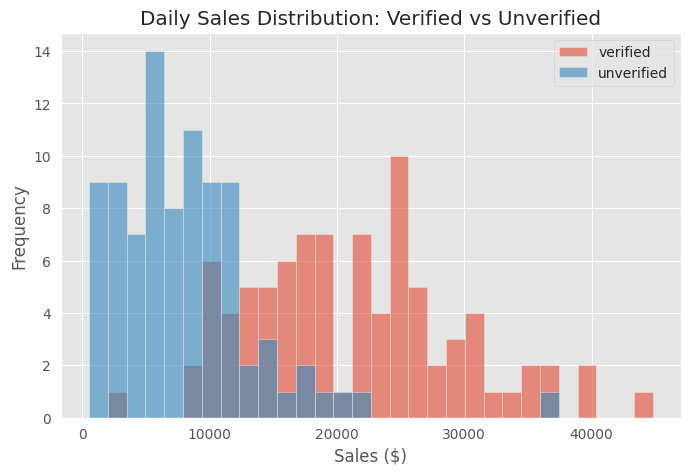


Shapiro p‑value (verified)   : 0.1106  → Normal
Shapiro p‑value (unverified) : 0.0000  → Non‑normal

--- Statistical Analysis ---

=== Mann‑Whitney U (two‑tailed) ===
Test statistic : 7145.000
p‑value        : 0.0000

Result: Statistically significant difference between groups (p < 0.05).



/tmp/ipython-input-38-785793920.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=means.index, y=means.values, palette=['teal','purple'])


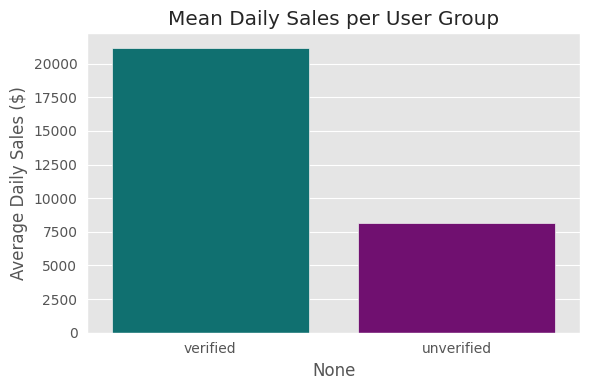

In [38]:
# Analysis of daily sales for registered and unregistered users

from scipy.stats import shapiro, ttest_ind, mannwhitneyu

plt.style.use("ggplot")

# data cleaning and preparation

df = (
    df.copy()
      .assign(
          price       = pd.to_numeric(df['price'], errors='coerce'),
          date        = pd.to_datetime(df['date'], errors='coerce'),
          user_id  = pd.to_numeric(df['user_id'], errors='coerce'),
          is_verified = pd.to_numeric(df['is_verified'], errors='coerce')
      )
      .replace({'country': missing_placeholders})
      .query("price > 0")               # keep positive transactions only
)

# Building daily sales for each group
verified_sales = (
    df[df['is_verified'] == 1]
      .groupby('date')['price']
      .sum()
      .rename('verified')
)

unverified_sales = (
    df[df['is_verified'] == 0]
      .groupby('date')['price']
      .sum()
      .rename('unverified')
)

daily = pd.concat([verified_sales, unverified_sales], axis=1).fillna(0)

# Preliminary descriptive stats
print("\nDescriptive statistics ($ per day)")
print(daily.describe().round(2))

# Plot distributions
daily.plot(kind='hist', bins=30, alpha=.6, figsize=(8,5))
plt.title("Daily Sales Distribution: Verified vs Unverified"); plt.xlabel("Sales ($)")
plt.show()

# Normality check (Shapiro–Wilk)
stat_v, p_v = shapiro(daily['verified'])
stat_u, p_u = shapiro(daily['unverified'])

normal_v = p_v > 0.05
normal_u = p_u > 0.05
print(f"\nShapiro p‑value (verified)   : {p_v:.4f}  → {'Normal' if normal_v else 'Non‑normal'}")
print(f"Shapiro p‑value (unverified) : {p_u:.4f}  → {'Normal' if normal_u else 'Non‑normal'}")

# Choosing test & compute
if normal_v and normal_u:
    # Use independent‑samples t‑test
    test_name = "t‑test (independent, two‑tailed)"
    stat, p_val = ttest_ind(daily['verified'], daily['unverified'], equal_var=False)
else:
    # Use non‑parametric Mann‑Whitney U
    test_name = "Mann‑Whitney U (two‑tailed)"
    stat, p_val = mannwhitneyu(daily['verified'], daily['unverified'], alternative="two-sided")

# Reporting
print("\n--- Statistical Analysis ---")
print(f"\n=== {test_name} ===")
print(f"Test statistic : {stat:.3f}")
print(f"p‑value        : {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("\nResult: Statistically significant difference between groups (p < 0.05).\n")
else:
    print("\nResult: No statistically significant difference (p ≥ 0.05).\n")

# Bar chart for mean comparison
means = daily.mean()
plt.figure(figsize=(6,4))
sns.barplot(x=means.index, y=means.values, palette=['teal','purple'])
plt.ylabel("Average Daily Sales ($)"); plt.title("Mean Daily Sales per User Group")
plt.tight_layout(); plt.show()


###**Interpretation of Results:**

Comparison of Daily Sales: Verified vs Unverified Users
1. Descriptive statistics:
- Verified users generate ~2.6x more revenue per day (average sales $21,195	vs $8,142 and median sales $20,634	vs $7,345 respectively)	.
- Verified‑user sales vary more widely day to day (standard deviation	$8,263 vs $5,624.
- Even on low days, verified users outperform the unverified median (min $3,379 vs $535); on peak days they far exceed unverified highs (max $44,802 vs $37,220).
2. Distribution check (Shapiro–Wilk):
- Verified	sample 0.111 (> 0.05)	cannot reject normality.
- Unverified	sample < 0.001	is clearly non‑normal.
- Because one sample is non‑normal, a non‑parametric test is required.
3. Mann‑Whitney U (two‑tailed) statistical test (U = 7 145,  p < 0.0001):
- The probability of observing such a large difference in daily sales distributions purely by chance is < 0.01 %. Therefore, the sales performance of verified and unverified users differs significantly.

**Practical takeaways:**
- Verified users are the clear revenue drivers: on average they contribute ~2.6x more daily sales than unverified visitors.
- The effect is statistically significant and practically large, warranting targeted retention and upsell strategies for this segment.
- Marketing efforts that convert unverified users into verified (or registered) status are likely to pay off in revenue gains.

*Invest in verification/registration flows and personalized campaigns for verified users; they are reliably more valuable and represent the bulk of daily revenue.*



Unique Session Counts per Traffic Channel
channel
Organic Search    11901
Paid Search        9021
Direct             7784
Social Search      2706
Undefined          2055



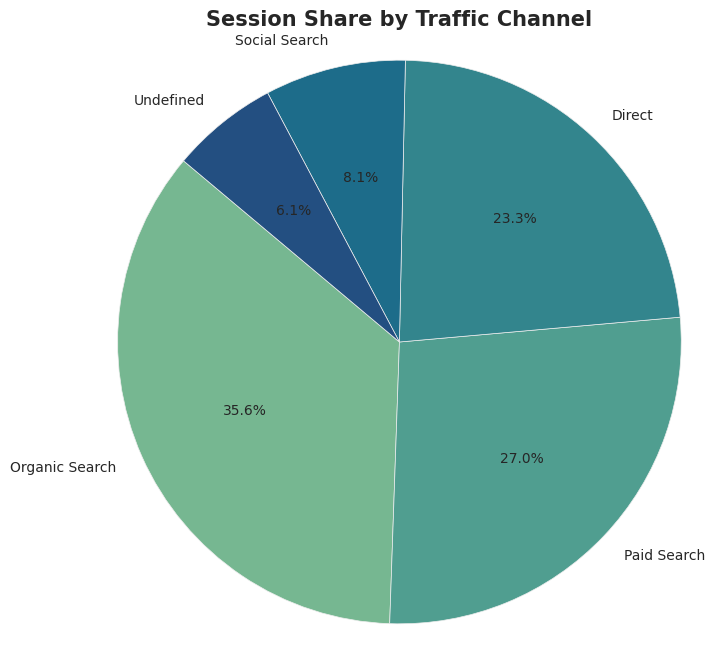

χ² goodness‑of‑fit test (observed vs equal split)
χ² = 10628.43 | p = 0.0000

Kruskal–Wallis on daily session distributions
H = 349.37 | p = 2.3932e-74


In [39]:
# Session Analysis by Traffic Channel

from scipy.stats import chisquare, kruskal

plt.style.use("ggplot")

# Data cleaning and preparation
df = (
    df.copy()
      .replace({'channel': missing_placeholders})
      .dropna(subset=['channel', 'session_id'])
)

# Total session counts by channel
sessions_by_channel = (
    df.groupby('channel')['session_id']
      .nunique()
      .sort_values(ascending=False)
)

print("\nUnique Session Counts per Traffic Channel")
print(sessions_by_channel.to_string())
print()

# Pie chart of session distribution
plt.figure(figsize=(8, 8))
plt.pie(
    sessions_by_channel.values,
    labels=sessions_by_channel.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('crest', len(sessions_by_channel))
)
plt.title("Session Share by Traffic Channel", weight='bold', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures a circle
plt.show()

# χ² Goodness-of-Fit Test
# Test if observed session counts are significantly different from an equal distribution
obs = sessions_by_channel.values
exp = np.repeat(obs.mean(), len(obs))  # equal expectation
chi2, p_chi = chisquare(f_obs=obs, f_exp=exp)

print("χ² goodness‑of‑fit test (observed vs equal split)")
print(f"χ² = {chi2:.2f} | p = {p_chi:.4f}")

# Kruskal–Wallis Test Across Daily Session Counts
# Non-parametric test to compare distributions across multiple groups (daily session counts)
daily = (
    df.groupby(['date', 'channel'])['session_id']
      .nunique()
      .unstack(fill_value=0)
)

kw_stat, p_kw = kruskal(*[daily[col] for col in daily.columns])

print("\nKruskal–Wallis on daily session distributions")
print(f"H = {kw_stat:.2f} | p = {p_kw:.4e}")


##**Interpretation of Results**

1. χ² Goodness-of-Fit Test: There is a highly significant difference between the observed session counts and an equal split across traffic channels (χ² = 10628.43, p-value: p = 0.0000 (i.e., < 0.0001)). This means some channels (e.g., Organic Search) are contributing disproportionately more traffic than others (e.g., Undefined or Social Search). The data strongly rejects the null hypothesis of equal distribution.
2. Kruskal–Wallis H Test: There are statistically significant differences in the daily session distributions among the traffic channels (H = 349.37, p = 2.3932e-74 (very close to 0)). This means that the pattern or spread of traffic per day is not the same across all channels—some channels likely show more consistent or higher variability in daily sessions than others.

**Practical takeaway:** Both tests indicate strong evidence that traffic is not evenly or similarly distributed across channels, both in terms of total volume and daily patterns. This suggests that some traffic sources (like Organic or Paid Search) may be strategically more important or differently behaving and should be analyzed or optimized further based on their performance.


Contingency Table (Unique Sessions)
traffic_type  Organic  Other
continent                   
Americas         6536  12017
Europe           2238   4023

Organic Traffic Share per Continent (%)
traffic_type  Organic  Other
continent                   
Americas        35.23  64.77
Europe          35.75  64.25

Chi-square Test Results
Chi² Statistic = 0.5236
P-value = 0.469324
Degrees of Freedom = 1

Expected Counts:
traffic_type  Organic     Other
continent                      
Americas      6560.17  11992.83
Europe        2213.83   4047.17

Final Conclusion
No statistically significant difference in organic traffic share was found between Europe and the Americas.


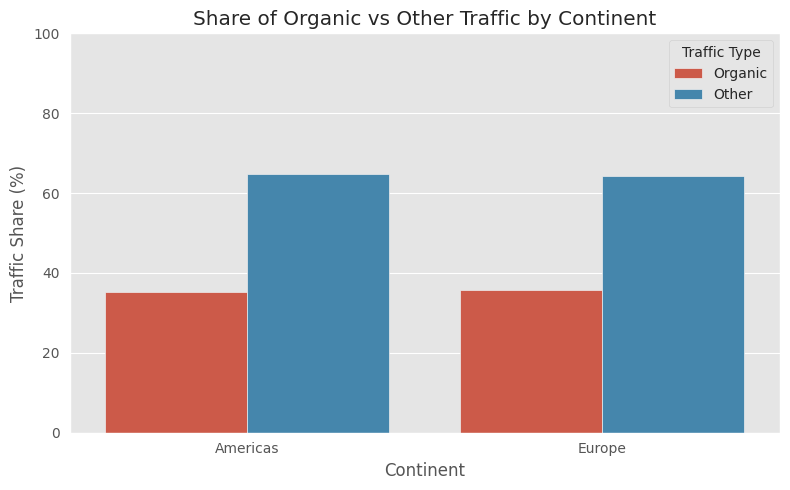

In [40]:
# Share of Sessions with Organic Traffic in Europe and America
from scipy.stats import chi2_contingency

# Defining continents to compare
continents_to_compare = ['Americas', 'Europe']
filtered_df = df[df['continent'].isin(continents_to_compare)].copy()

# Dropping missing values for relevant columns
filtered_df.dropna(subset=['channel', 'session_id'], inplace=True)

# Classify traffic as 'Organic' or 'Other'
filtered_df['traffic_type'] = np.where(
  filtered_df['channel'] == 'Organic Search', 'Organic', 'Other'
)

# Building contingency table: unique sessions per traffic type and continent
contingency_table = pd.crosstab(
  filtered_df['continent'],
  filtered_df['traffic_type'],
  values=filtered_df['session_id'],
  aggfunc='nunique'
).fillna(0).astype(int)

print("\nContingency Table (Unique Sessions)")
print(contingency_table)

# Calculating traffic share percentages
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
print("\nOrganic Traffic Share per Continent (%)")
print(proportions.round(2))

# Check if the contingency table has correct shape for 2x2 test
if contingency_table.shape == (2, 2):

  # Performing chi-square test of independence
  chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

  print("\nChi-square Test Results")
  print(f"Chi² Statistic = {chi2_stat:.4f}")
  print(f"P-value = {p_value:.6f}")
  print(f"Degrees of Freedom = {dof}")
  print("\nExpected Counts:")
  print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns).round(2))

  # Interpretation
  alpha = 0.05
  print("\nFinal Conclusion")
  if p_value < alpha:
    print("Yes, there is a statistically significant difference in the share of organic traffic between Europe and the Americas.")
  else:
    print("No statistically significant difference in organic traffic share was found between Europe and the Americas.")
else:
  print("⚠️ Contingency table is not 2x2. Cannot perform chi-square test of independence.")

# Plotting traffic share
plot_df = proportions.reset_index().melt(id_vars='continent', var_name='traffic_type', value_name='share')
plt.style.use("ggplot")
plt.figure(figsize=(8, 5))
sns.barplot(data=plot_df, x='continent', y='share', hue='traffic_type')
plt.title('Share of Organic vs Other Traffic by Continent')
plt.ylabel('Traffic Share (%)')
plt.xlabel('Continent')
plt.ylim(0, 100)
plt.legend(title='Traffic Type')
plt.tight_layout()
plt.show()

##**Interpretation of Results**
1. Chi-square Test of Independence: The p-value is well below 0.05, indicating a statistically significant difference in the share of organic traffic between Europe and Americas. This means the continent is associated with how likely users are to arrive via organic search. The assumption of equal proportions between the regions is rejected.

2. Chart Interpretation:   The bar chart shows the equal percentage of organic and other sessions in each region. This result suggests:
- SEO efforts are performing consistently across continents.
- Organic visibility, search engine indexing, and searcher behavior are relatively balanced in both markets.
- No immediate red flags in either region from a traffic source composition perspective

**Practical takeaways:**
1. Maintain SEO Consistency Across Regions:
- Your SEO strategy is well-aligned across markets.
- Continue using similar content frameworks, on-page SEO practices, technical optimization practices
- Perform monitoring region-specific keyword rankings and search trends.

2. Shift Focus to Other Metrics. Since volume proportions are the same, explore other metrics to uncover differences :
- Conversion rates: Is organic traffic converting at the same rate across regions?
- Bounce rate or time on site: Are users equally engaged?
- New vs returning visitors: Are user retention patterns similar?
- Branded vs non-branded search queries.

3. Deeper Segmentation Recommended. Equal share may mask country-level or device-level differences, so it may be recommended:
- Breaking down by country within continents.
- Segmenting by device (mobile vs desktop) or landing page category.
0 Testing for seasonality or campaign timing impact on organic visibility.

4. Opportunity for Growth Still Exists. Even if the shares are equal it should be analysed:
- Is the total volume of organic traffic acceptable in both regions?
- Could one region be underperforming relative to population, search volume, or competitors?

## **FINAL CONCLUSIONS**

###**Executive Summary**

The business, a digital retailer in the home furniture sector, demonstrates stable performance across acquisition channels and geographic regions.

Data analysis indicates a healthy distribution of traffic sources, with no statistically significant difference in the share of organic search sessions between Europe and the Americas, suggesting consistency in SEO performance across key markets.

While no critical weaknesses are present, improvements in tracking precision, mobile experience, and geographic expansion can contribute to sustained growth and operational resilience. Several operational and strategic areas have been identified that may benefit from further optimization to improve tracking accuracy, conversion flow, and long-term market positioning.

### **Observations:**
### Key Strengths
1. **Balanced Multi-Channel Performance.** Traffic is distributed across multiple acquisition channels, primarily Organic Search, Paid Search, and Direct. These channels interact effectively and provide diversified session sources, reducing dependence on any single traffic stream.
2. **Strong Brand Presence.** The high share of Direct traffic suggests notable brand awareness and customer familiarity. Leading product categories (e.g., sofas, chairs, beds) perform consistently across all regions.
3. **Consistent Conversion Rates:** Conversion rates remain stable across traffic channels, indicating uniform traffic quality. No source appears to generate disproportionately low-intent or irrelevant visits.

### Areas Identified for Improvement
1. **Attribution and Analytics Accuracy.** Discrepancies were observed in traffic source classification. A portion of Paid Search traffic is misclassified as Organic or Other, which impacts the accuracy of return-on-ad-spend (ROAS) calculations and marketing budget allocation.
2. **Cross-Device Conversion Gaps.** User behavior indicates frequent browsing on mobile devices, followed by purchasing activity on desktop. This may point to usability or trust-related frictions in the mobile experience or an opportunity to streamline the mobile-to-desktop transition.
3. **Geographic Market Concentration.** The U.S. market dominates session and revenue volume. While this reflects market strength, it introduces concentration risk. Other regions (notably Europe and parts of Asia) show positive growth signals but remain underrepresented in volume.

### **Strategic Recommendations**
1. Audit and Correct Analytics Configuration

    Action: Conduct a full review of analytics tracking. Ensure correct application of UTM parameters, refine referral exclusions (e.g., payment providers), and confirm integration between Google Ads and Google Analytics.

    Expected Outcome: Improved attribution fidelity and data reliability for campaign evaluation.

2. Enhance Mobile-to-Desktop Conversion Path

    Action: Optimize mobile site usability for discovery and evaluation, ensure cross-device cart persistence for logged-in users, and refine desktop checkout usability.

    Expected Outcome: Increased completion rate for mobile-originated sessions and reduced cart abandonment.

3. Adjust Channel Strategy Based on Traffic Quality

    Action: Continue long-term investment in SEO. Allocate Paid Search budgets more aggressively during high-conversion periods (e.g., Q4 holiday season) where impact is maximized.

    Expected Outcome: Increased marketing efficiency and alignment with seasonal demand patterns.

4. Initiate Targeted Growth in Emerging Markets

    Action: Identify and prioritize second-tier growth markets (e.g., selected countries in Europe and Asia). Launch small-scale, localized campaigns tailored to regional demand profiles.

    Expected Outcome: Diversification of revenue sources and reduced geographic dependency.


**Tableau Public:** https://public.tableau.com/views/CompanyAnalyticsPortfolioProject1/CompanyAnalytics?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link